 # Import libraries

In [ ]:
library(fredr)
library(ggplot2)
library(forecast)
fredr_set_key("d12020aa815dd3c82d419e68256020c4")
library(tseries)
library(zoo)
library(urca) #for kpss test

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




# DATA A2 : Vehicle Miles Traveled

In [ ]:
dat2<-fredr(series_id = "TRFVOLUSM227NFWA",
          observation_start = as.Date("1972-01-01"),observation_end = as.Date("2008-12-31"))


In [ ]:
head(dat2)

date,series_id,value,realtime_start,realtime_end
<date>,<chr>,<dbl>,<date>,<date>
1972-01-01,TRFVOLUSM227NFWA,92465,2024-04-28,2024-04-28
1972-02-01,TRFVOLUSM227NFWA,88272,2024-04-28,2024-04-28
1972-03-01,TRFVOLUSM227NFWA,102926,2024-04-28,2024-04-28
1972-04-01,TRFVOLUSM227NFWA,103238,2024-04-28,2024-04-28
1972-05-01,TRFVOLUSM227NFWA,110945,2024-04-28,2024-04-28
1972-06-01,TRFVOLUSM227NFWA,113265,2024-04-28,2024-04-28


In [ ]:
tail(dat2)

date,series_id,value,realtime_start,realtime_end
<date>,<chr>,<dbl>,<date>,<date>
2008-07-01,TRFVOLUSM227NFWA,261600,2024-04-28,2024-04-28
2008-08-01,TRFVOLUSM227NFWA,260609,2024-04-28,2024-04-28
2008-09-01,TRFVOLUSM227NFWA,239607,2024-04-28,2024-04-28
2008-10-01,TRFVOLUSM227NFWA,255848,2024-04-28,2024-04-28
2008-11-01,TRFVOLUSM227NFWA,236465,2024-04-28,2024-04-28
2008-12-01,TRFVOLUSM227NFWA,241742,2024-04-28,2024-04-28


In [ ]:
dat2 <- subset(dat2, select = c(date, value))

head(dat2)

date,value
<date>,<dbl>
1972-01-01,92465
1972-02-01,88272
1972-03-01,102926
1972-04-01,103238
1972-05-01,110945
1972-06-01,113265


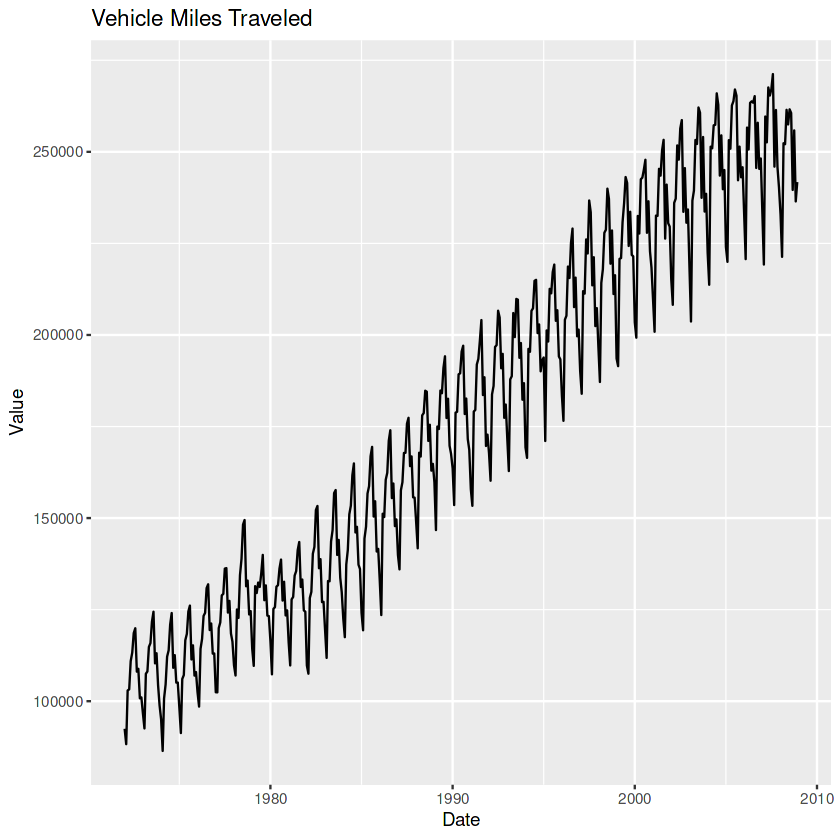

In [ ]:
ggplot(dat2, aes(x = date, y = value)) +
 geom_line() +
 labs(title = "Vehicle Miles Traveled", x = "Date", y = "Value")

In [ ]:
mean_value <- mean(dat2$value)
std_value <- sd(dat2$value)
cat("Mean:", mean_value, "\n")
cat("Standard Deviation:", std_value, "\n")

Mean: 178146.4 
Standard Deviation: 50783.26 


In [ ]:
ts_data <- ts(dat2$value, frequency = 12, start = c(1972,1))

In [ ]:
head(ts_data)

,Jan,Feb,Mar,Apr,May,Jun
1972,92465,88272,102926,103238,110945,113265


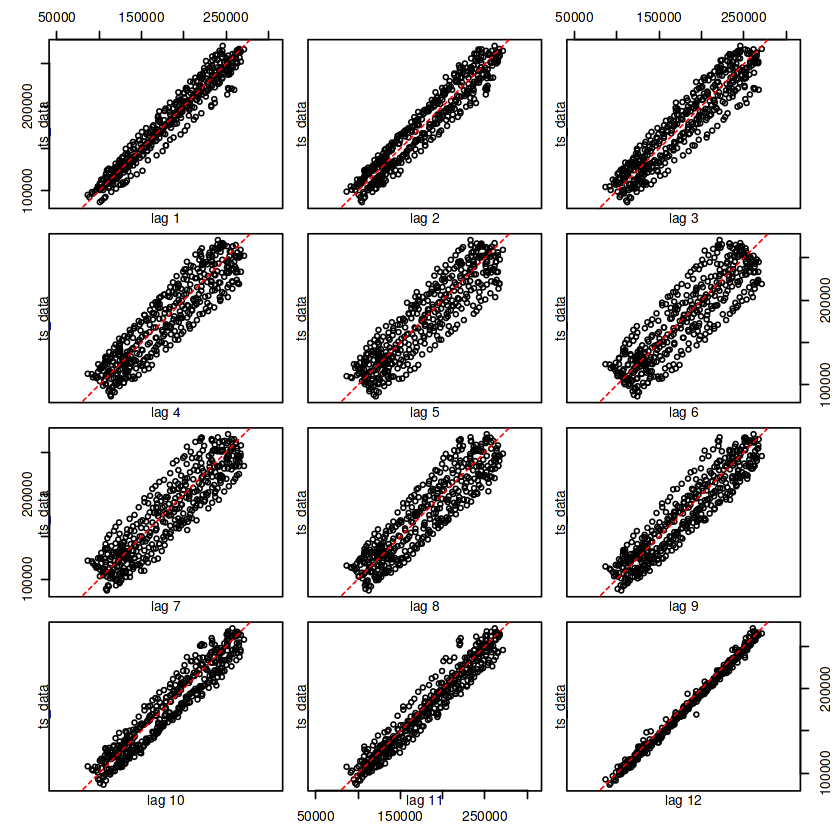

In [ ]:
lag.plot(ts_data,lag=12,layout=c(4,3),do.lines=FALSE,diag.col="red",col.main="blue")

# Analyse Statistique

**1.Décomposition paramétrique**
    
    les composantes de tendance et de saisonnalité de cette série temporelle ont une amplitude relativement constante et ne sont pas proportionnelles au niveau de la série, alors c'est une décomposition additive.


In [ ]:
decomp <- decompose(ts_data, type = "additive")
trend <- decomp$trend
seasonal <- decomp$seasonal
residuals <- decomp$random

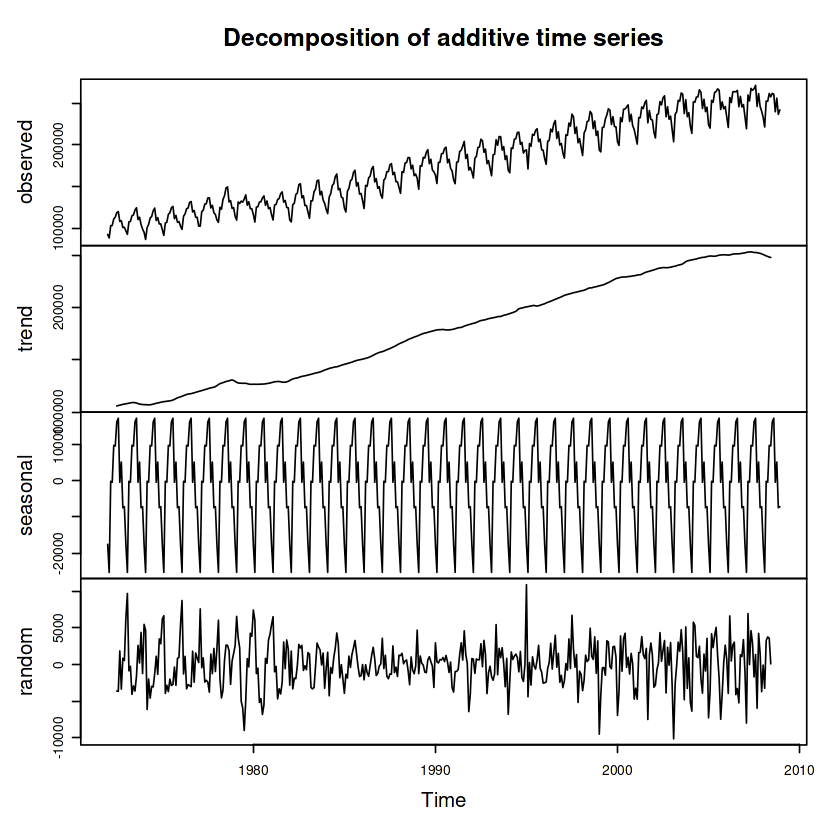

In [ ]:
plot(decomp)

**2.Auto-covariance**
    
    La fonction d’autocovariance est une mesure statistique qui quantifie la covariance entre les observations d’une série temporelle (ou en générale un processus stochastique) à des instants différents. Elle est souvent utilisée pour examiner les relations de dépendance entre les valeurs d’une série temporelle et pour détecter des motifs périodiques.

La fonction d’autocovariance $γ(h)$ pour une série temporelle $X_t$ à des retards $h$ est définie comme suit :

$γ(h) =\frac{1}{n} \sum_{t=1}^{n-h} (X_t - \bar{X})(X_{t+h} - \bar{X})$

où :

$n$ : est la longueur de la série temporelle,


$X_t$ : est la valeur de la série temporelle au temps t,

$\bar{X}$ : est la moyenne de la série temporelle.

  
Alors :
* Si $γ(h)$ est proche de zéro, cela suggère une faible covariance entre les observations séparées par un décalage de $h$.
* Si $γ(h)$ est positive, cela indique une relation positive entre les observations décalées de $h$ périodes.
* Si $γ(h)$ est négative, cela indique une relation négative entre les observations décalées de $h$ périodes.


In [ ]:
retard = 0
Xt = ts_data[1:(length(ts_data)-retard)]
Xt_retard = ts_data[(retard+1):length(ts_data)]
n = length(Xt)

cov(Xt,Xt_retard)

[1] 2578939788

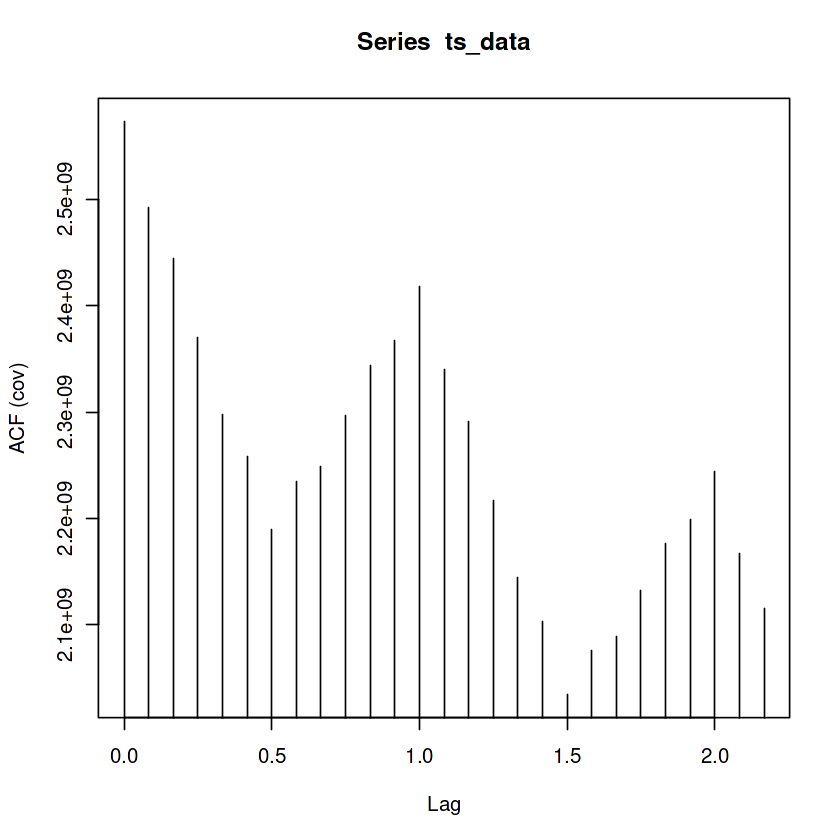

In [ ]:
autocovariance_AP <- acf(ts_data, plot = FALSE, type = "covariance")
plot(autocovariance_AP)

On peut voir quelques faible covariance entre les observations.

# Stationnarité

**La stationnarité est une propriété importante des séries temporelles. Une série temporelle est dite stationnaire si ses propriétés statistiques telles que la moyenne, la variance et la covariance restent constantes au fil du temps.**

In [ ]:
rolling_mean = rollmean(ts_data, k=4, align='center')
c(length(rolling_mean),length(ts_data))

[1] 441 444

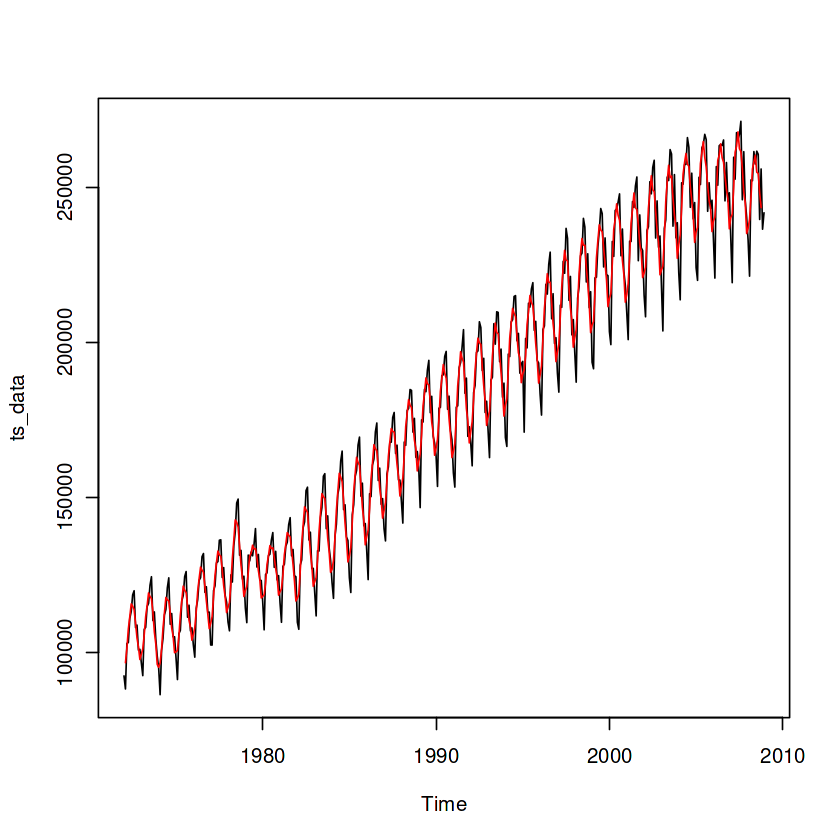

In [ ]:
plot(ts_data)
lines(rolling_mean,col='red')

In [ ]:
window_size <- 10  # Adjust this value as needed

# Calculate rolling mean
rolling_mean <- rollapply(ts_data, width = window_size, FUN = mean, align = "right")

# Calculate rolling standard deviation
rolling_sd <- rollapply(ts_data, width = window_size, FUN = sd, align = "right")




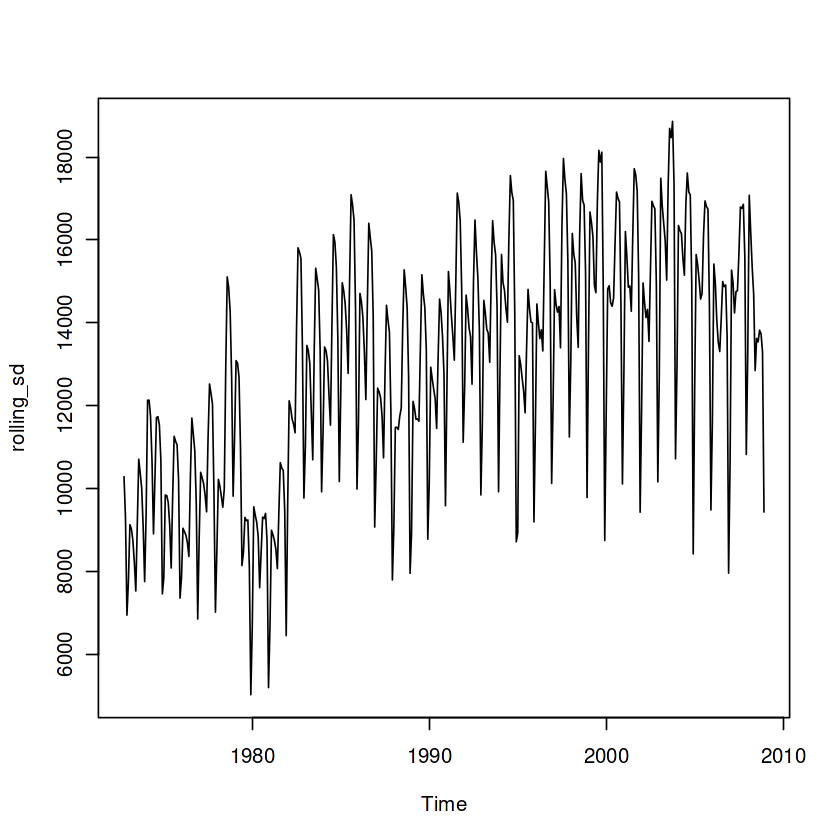

In [ ]:
plot(rolling_sd)

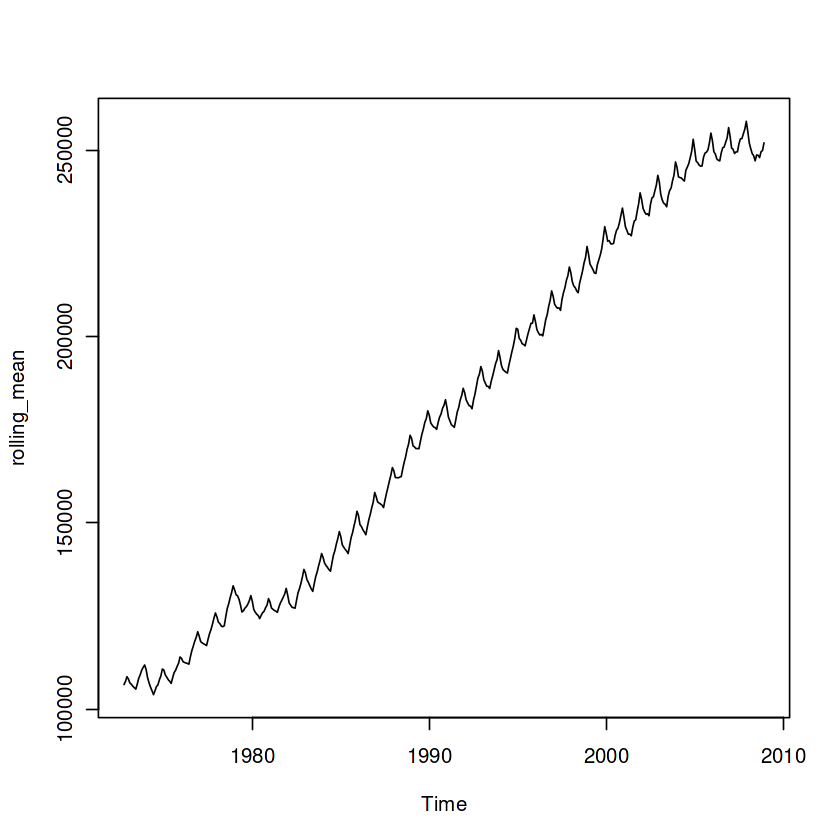

In [ ]:
plot(rolling_mean)

**L'absence d'une moyenne mobile constante suggère la présence d'un comportement non stationnaire dans les données.**

# Test de stationnarité: Test ADF

Le test de stationnarité ADF (Augmented Dickey-Fuller) est un test statistique utilisé pour tester l’hypothèse nulle selon laquelle une série temporelle donnée n’est pas stationnaire. Les hypothèses du test ADF sont les suivantes :

$H_0$ (hypothèse nulle) : La série temporelle n'est pas stationnaire.
$H_1$ (hypothèse alternative) : La série temporelle est stationnaire.

* Si la valeur de la statistique de test est inférieure à la valeur critique, l’hypothèse nulle est rejetée, ce qui signifie que la série temporelle est stationnaire.

* Sinon, on ne peut pas rejeter l’hypothèse nulle, ce qui signifie que la série temporelle est non-stationnaire.

In [ ]:
adf.test(ts_data)

Warning message in adf.test(ts_data):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ts_data
Dickey-Fuller = -5.7457, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


**P-valeur est inférieure à 0,05, on rejette l’hypothèse nulle et on conclut que la série temporelle est stationnaire.**

**Le test ADF suppose l'absence d'autocorrélation, de saisonnalité et de ruptures structurelles. Si l'une de ces hypothèses n'est pas respectée, les résultats du test ADF peuvent être trompeurs.**

# Test de Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

In [ ]:
kpss_test <- ur.kpss(ts_data)

summary(kpss_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 7.3743 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


**La statistique du test (7,3743) est supérieure à toutes les valeurs critiques fournies (0,347, 0,463, 0,574, 0,739) pour des niveaux de signification de 10 %, 5 %, 2,5 % et 1 %. Cela suggère que nous rejetterions l'hypothèse nulle de stationnarité à n'importe lequel de ces niveaux de signification.**

**Par conséquent, sur la base du test KPSS, les preuves suggèrent que notre série temporelle est non stationnaire.**

# Différenciation : Technique de stationnarisation

Cette méthode consiste à prendre la différence entre les valeurs de la série à des moments différents. La différence peut être prise plusieurs fois jusqu’à ce que la série soit stationnaire.

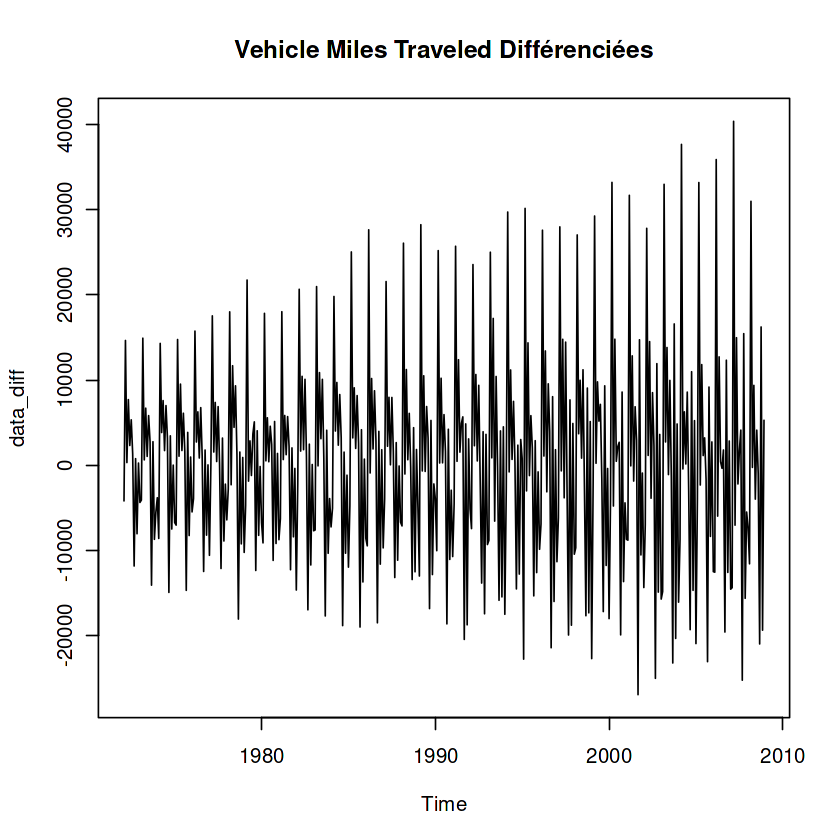

In [ ]:
data_diff <- diff(ts_data,lag =1,differences = 1)

plot(data_diff, type="l", main="Vehicle Miles Traveled Différenciées")

In [ ]:
kpss_test <- ur.kpss(data_diff)

summary(kpss_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0075 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


**La statistique du test (0,0075) est beaucoup plus petite que toutes les valeurs critiques (0,347, 0,463, 0,574, 0,739) pour tous les niveaux de signification. Cela suggère que nous acceptons l'hypothèse nulle de stationnarité à tous ces niveaux de signification.**

# Ajustement

Nous prendrons en considération les tendances et les schémas saisonniers

# 1. Régression linéaire simple:

In [ ]:
t=1:length(ts_data)
linear_model <- lm(ts_data ~ t)
summary(linear_model)


Call:
lm(formula = ts_data ~ t)

Residuals:
   Min     1Q Median     3Q    Max 
-37415  -7849    905  10773  26363 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 93349.917   1303.407   71.62   <2e-16 ***
t             381.108      5.076   75.08   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13710 on 442 degrees of freedom
Multiple R-squared:  0.9273,	Adjusted R-squared:  0.9271 
F-statistic:  5637 on 1 and 442 DF,  p-value: < 2.2e-16


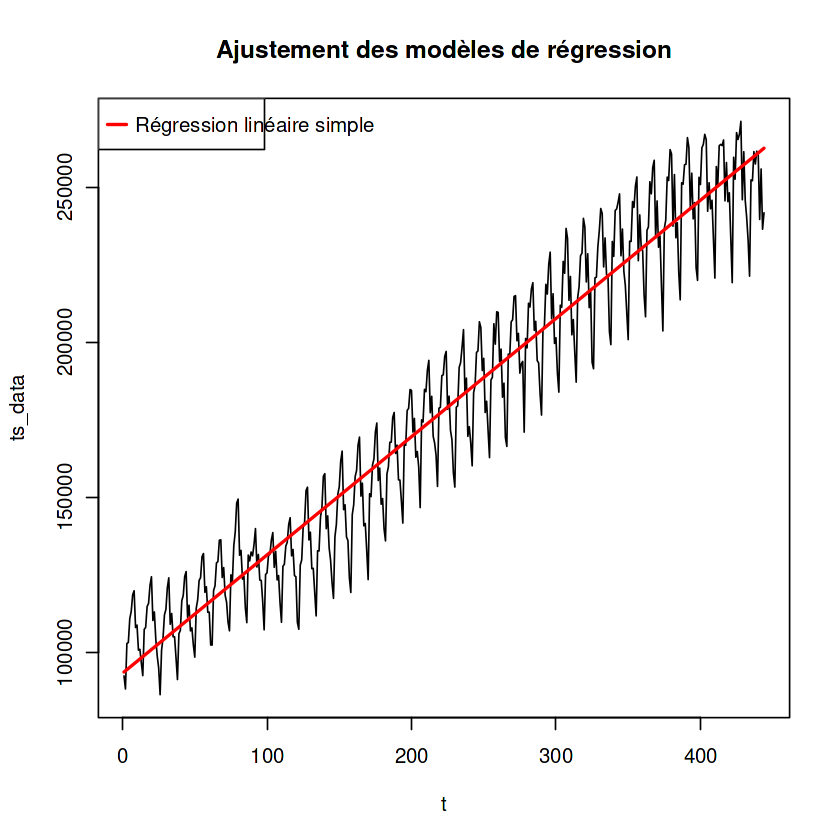

In [ ]:
plot(t, ts_data,type='l', main="Ajustement des modèles de régression")
lines(t, linear_model$fitted.values, col="red", lwd=2)
legend("topleft", legend="Régression linéaire simple",
      col="red", lty=1, lwd=2)

# 2. Régression linéaire multiple:

In [ ]:
poly_model <- lm(ts_data ~ t+I(t^2))
summary(poly_model)


Call:
lm(formula = ts_data ~ t + I(t^2))

Residuals:
   Min     1Q Median     3Q    Max 
-40139  -7722   1313  10802  27257 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 9.653e+04  1.952e+03  49.445   <2e-16 ***
t           3.383e+02  2.026e+01  16.696   <2e-16 ***
I(t^2)      9.626e-02  4.409e-02   2.183   0.0295 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13650 on 441 degrees of freedom
Multiple R-squared:  0.9281,	Adjusted R-squared:  0.9277 
F-statistic:  2845 on 2 and 441 DF,  p-value: < 2.2e-16


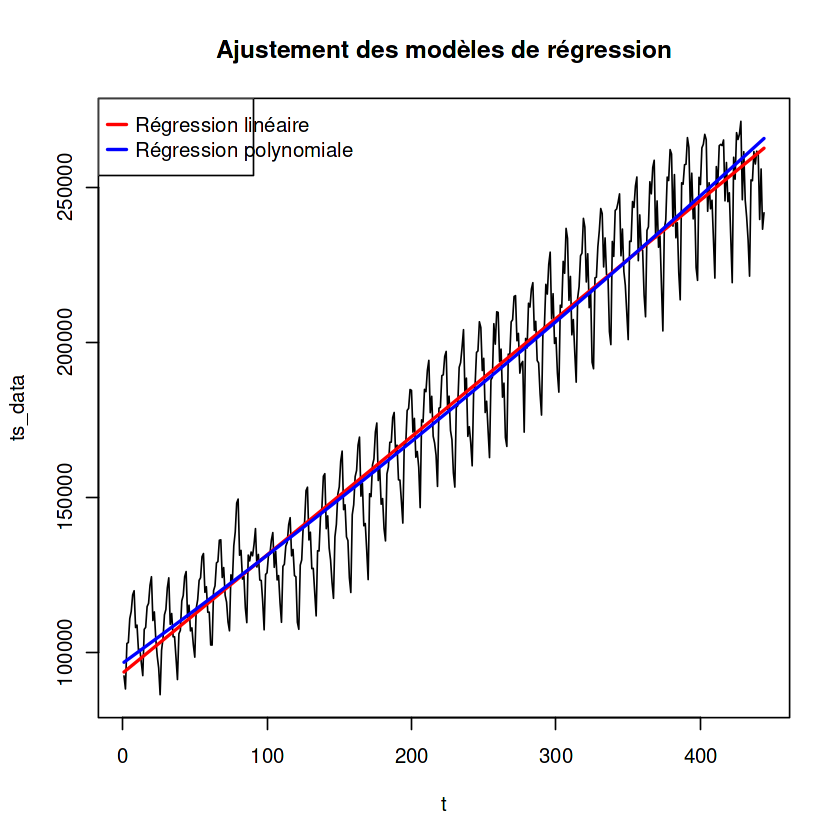

In [ ]:
plot(t,ts_data,type='l', main="Ajustement des modèles de régression")
lines(t, linear_model$fitted.values, col="red", lwd=2)
lines(t, poly_model$fitted.values, col="blue", lwd=2)
legend("topleft", legend=c("Régression linéaire", "Régression polynomiale"),
      col=c("red", "blue"), lty=1, lwd=2)

# 3. Prédiciton des valeurs au futur

In [ ]:
t_futur = (length(ts_data)+1):(length(ts_data)+20)
predict_linear=predict(linear_model, newdata=data.frame(t = t_futur))
predict_poly = predict(poly_model, newdata=data.frame(t = t_futur))

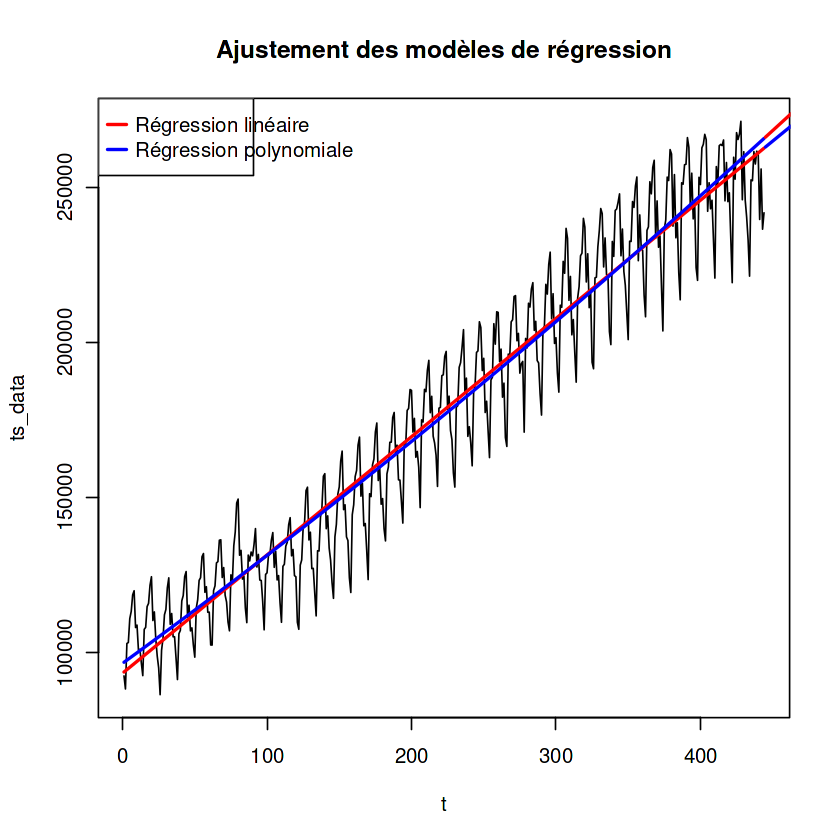

In [ ]:
plot(t,ts_data,type='l', main="Ajustement des modèles de régression")
lines(t, linear_model$fitted.values, col="red", lwd=2)
lines(t, poly_model$fitted.values, col="blue", lwd=2)
legend("topleft", legend=c("Régression linéaire", "Régression polynomiale"),
      col=c("red", "blue"), lty=1, lwd=2)

lines(t_futur,predict_linear,col="blue", lwd=2)
lines(t_futur,predict_poly,col="red", lwd=2)

# 4. Analyse des résidus

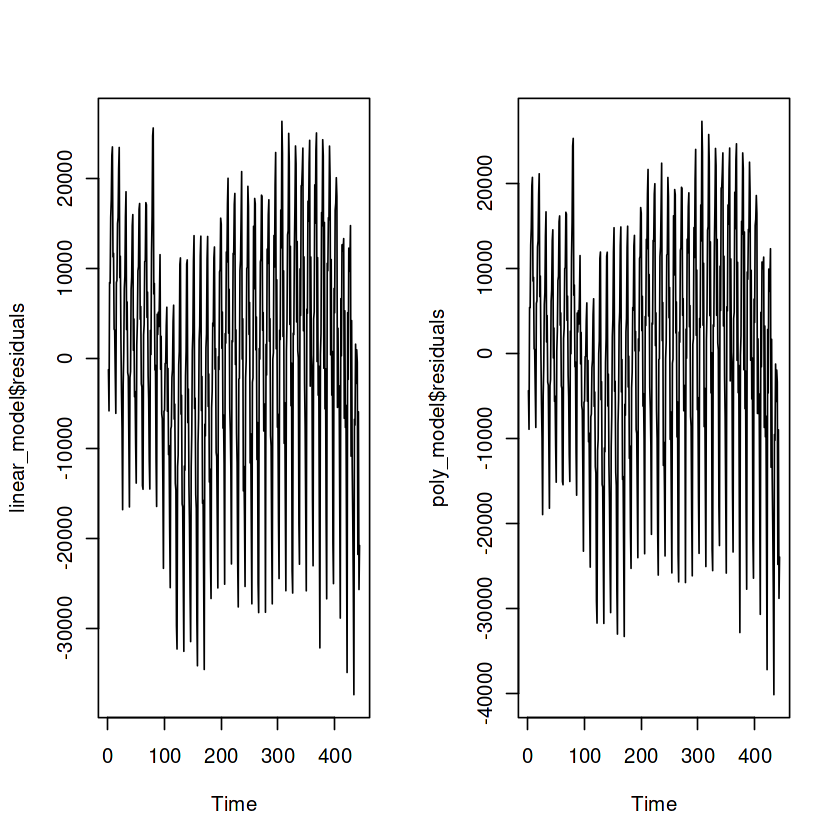

In [ ]:
par(mfrow=c(1,2))
plot.ts(linear_model$residuals)
plot.ts(poly_model$residuals)

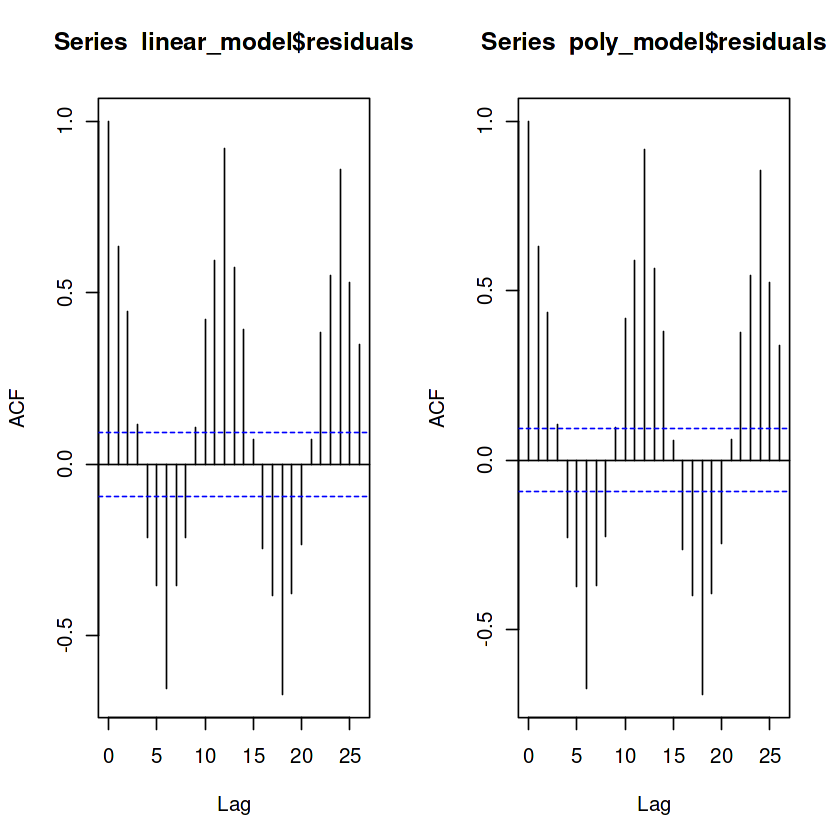

In [ ]:
par(mfrow=c(1,2))
acf(linear_model$residuals)
acf(poly_model$residuals)

**l’ACF présente un schéma cyclique ou périodique, cela pourrait indiquer une structure temporelle ou saisonnière non capturée par le modèle.**

# 5. Ajustement des composantes saisonnières :

In [ ]:
n= length(ts_data)
t=1 : length(ts_data)
transformer = function(t){
MC=matrix(0, length(t), 6)
MS=matrix(0, length(t), 6)
for (i in 1:6)
  MC[,i]=cos(2 *pi *t * i/12)
for (i in 1:6)
  MS[,i]=sin(2 * pi * t * i/12)
return(list(MC=MC, MS=MS))
}
mixed_model=lm(ts_data~poly(t,2,raw=TRUE) + transformer(t)$MC + transformer(t)$MS)
summary(mixed_model)


Call:
lm(formula = ts_data ~ poly(t, 2, raw = TRUE) + transformer(t)$MC + 
    transformer(t)$MS)

Residuals:
   Min     1Q Median     3Q    Max 
-24054  -3931   1081   4169  15821 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              9.674e+04  8.686e+02 111.377  < 2e-16 ***
poly(t, 2, raw = TRUE)1  3.371e+02  9.016e+00  37.391  < 2e-16 ***
poly(t, 2, raw = TRUE)2  9.707e-02  1.963e-02   4.946 1.09e-06 ***
transformer(t)$MC1      -1.324e+04  4.074e+02 -32.488  < 2e-16 ***
transformer(t)$MC2       8.276e+02  4.074e+02   2.031 0.042846 *  
transformer(t)$MC3       3.260e+03  4.074e+02   8.002 1.15e-14 ***
transformer(t)$MC4       3.918e+02  4.074e+02   0.962 0.336795    
transformer(t)$MC5       1.471e+03  4.089e+02   3.597 0.000359 ***
transformer(t)$MC6      -4.350e+01  3.221e+02  -0.135 0.892629    
transformer(t)$MS1      -7.994e+03  4.076e+02 -19.613  < 2e-16 ***
transformer(t)$MS2      -2.218e+03  4.074e+02  -5.444 8.78e-08 **

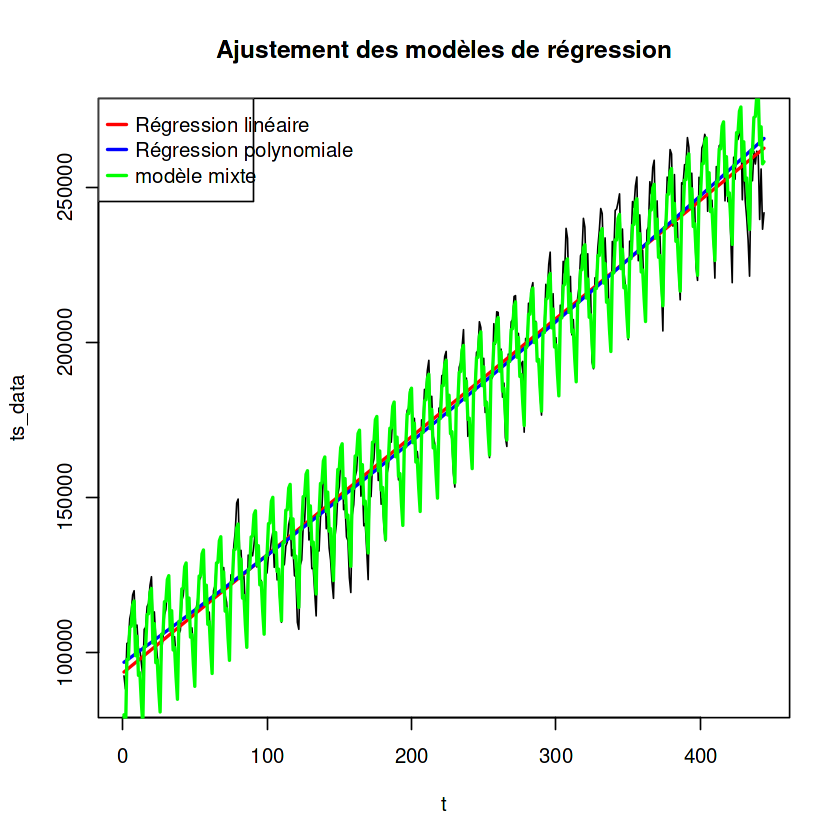

In [ ]:
plot(t,ts_data,type='l', main="Ajustement des modèles de régression")
lines(t, linear_model$fitted.values, col="red", lwd=2)
lines(t, poly_model$fitted.values, col="blue", lwd=2)
lines(t, mixed_model$fitted.values, col="green", lwd=2)

legend("topleft", legend=c("Régression linéaire", "Régression polynomiale", "modèle mixte"),
      col=c("red", "blue", "green"), lty=1, lwd=2)

In [ ]:
length(ts_data)

[1] 444

In [ ]:
t_futur = 445:500
nouvelle_observation <- data.frame(t=t_futur,MC=transformer(t_futur)$MC, MS=transformer(t_futur)$MS)

# Utiliser la fonction predict pour faire la prédiction
prediction <- predict(mixed_model, newdata = nouvelle_observation)

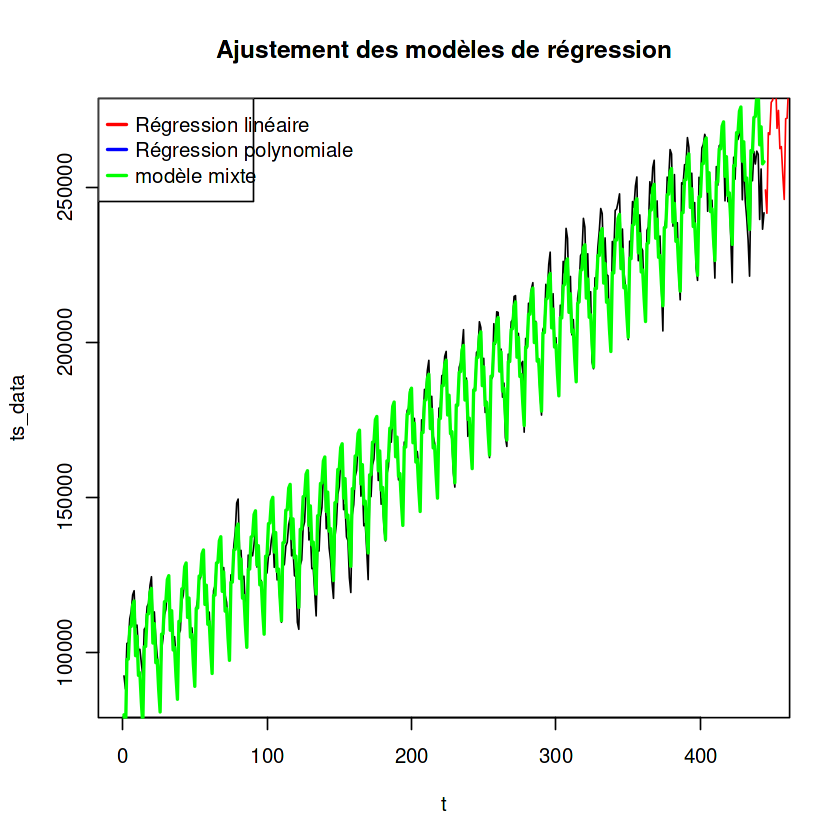

In [ ]:
plot(t,ts_data,type='l', main="Ajustement des modèles de régression")

lines(t, mixed_model$fitted.values, col="green", lwd=2)
lines(t_futur,prediction,col="red",type='l')


legend("topleft", legend=c("Régression linéaire", "Régression polynomiale", "modèle mixte"),
      col=c("red", "blue", "green"), lty=1, lwd=2)

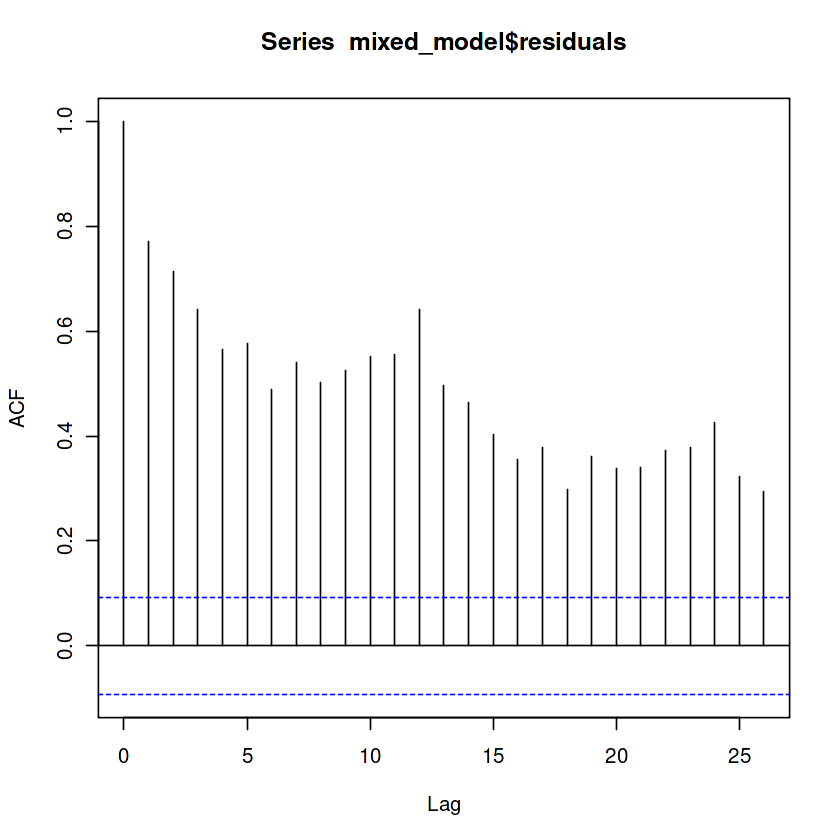

In [ ]:
acf(mixed_model$residuals)

En observant la fonction ACF, une autocorrélation significative et lantement décroissante dans les résidus de ce modèle indique que le modèle ne capture pas complètement la variabilité des données et qu’il y a des informations non expliquées.

# 6. Comparaison des modèles

In [ ]:
AIC(linear_model, poly_model, mixed_model)
BIC(linear_model, poly_model, mixed_model)

,df,AIC
,<dbl>,<dbl>
linear_model,3,9722.934
poly_model,4,9720.161
mixed_model,16,9012.263


,df,BIC
,<dbl>,<dbl>
linear_model,3,9735.221
poly_model,4,9736.544
mixed_model,16,9077.796


Le modèle mixte est le meilleur selon l'AIC et le BIC

# ARIMA

* **ARIMA** signifie **Autoregressive Integrated Moving Average Model**. Il appartient à une classe de modèles qui explique une série temporelle donnée sur la base de ses propres valeurs passées - c'est-à-dire ses propres décalages et les erreurs de prévision décalées. L'équation peut être utilisée pour prévoir les valeurs futures. Toute série temporelle « non saisonnière » qui présente des schémas et n'est pas un bruit blanc aléatoire peut être modélisée à l'aide de modèles ARIMA.
* **Les modèles ARIMA** sont spécifiés par trois paramètres d'ordre : (p, d, q)
        p est l'ordre du terme AR
        q est l'ordre du terme MA
        d est le nombre de différentiations nécessaires pour rendre la série temporelle stationnaire

* **Autorégression AR(p)** - modèle de régression qui utilise la relation dépendante entre une observation actuelle et les observations d'une période antérieure. Une composante autorégressive (AR(p)) fait référence à l'utilisation de valeurs passées dans l'équation de régression pour la série temporelle.

* **I(d) Intégration** - utilise la différenciation des observations (soustraction d'une observation de l'observation du pas de temps précédent) afin de rendre la série temporelle stationnaire. La différenciation implique la soustraction des valeurs actuelles d'une série à ses valeurs antérieures un nombre d de fois.

* **MA(q) Moyenne mobile** - modèle qui utilise la dépendance entre une observation et une erreur résiduelle d'un modèle de moyenne mobile appliqué à des observations décalées. Une composante de moyenne mobile représente l'erreur du modèle comme une combinaison des termes d'erreur précédents. L'ordre q représente le nombre de termes à inclure dans le modèle.

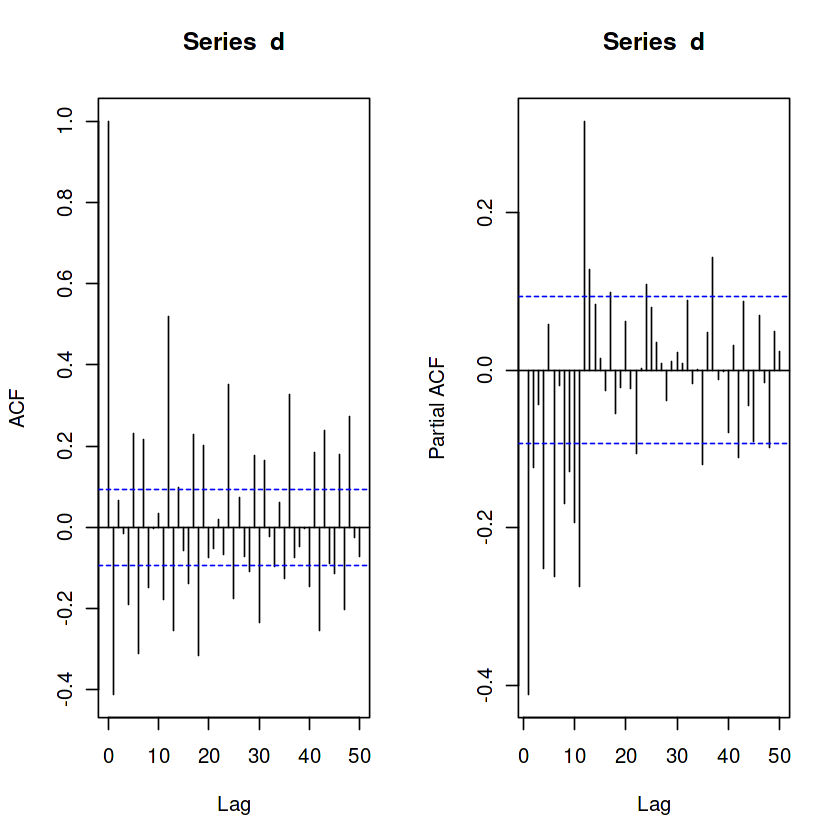

In [ ]:
d = diff(mixed_model$residuals)
par(mfrow=c(1,2))
acf(d, 50)
pacf(d,50)

Nous pouvons constater qu'il est difficile de déterminer **p** et **q** à partir des tracés de l'acf et du pacf.
Nous pouvons utiliser la fonction **auto.arima()** du module **forecast**.

In [ ]:
 ts_data.res<-mixed_model$residuals

In [ ]:
library(forecast)
ARIMA=auto.arima(ts_data.res,d=1,trace=TRUE)



 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : 8453.27
 ARIMA(0,1,0) with drift         : 8574.051
 ARIMA(1,1,0) with drift         : 8493.645
 ARIMA(0,1,1) with drift         : 8476.844
 ARIMA(0,1,0)                    : 8572.156
 ARIMA(1,1,2) with drift         : 8475.422
 ARIMA(2,1,1) with drift         : 8454.797
 ARIMA(3,1,2) with drift         : 8445.292
 ARIMA(3,1,1) with drift         : 8451.847
 ARIMA(4,1,2) with drift         : 8422.67
 ARIMA(4,1,1) with drift         : 8442.711
 ARIMA(5,1,2) with drift         : 8423.538
 ARIMA(4,1,3) with drift         : Inf
 ARIMA(3,1,3) with drift         : 8405.686
 ARIMA(2,1,3) with drift         : 8449.804
 ARIMA(3,1,4) with drift         : 8407.612
 ARIMA(2,1,4) with drift         : 8438.14
 ARIMA(4,1,4) with drift         : 8381.468
 ARIMA(5,1,4) with drift         : Inf
 ARIMA(4,1,5) with drift         : 8371.325
 ARIMA(3,1,5) with drift         : 8408.99
 ARIMA(5,1,5) with drift     

le meilleur modèle c'est **ARIMA(4,1,2)**

Warning message in adf.test(Model.res$residuals):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  Model.res$residuals
Dickey-Fuller = -7.9789, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary



	Ljung-Box test

data:  Residuals from ARIMA(4,1,2)
Q* = 9.2867, df = 4, p-value = 0.05432

Model df: 6.   Total lags used: 10



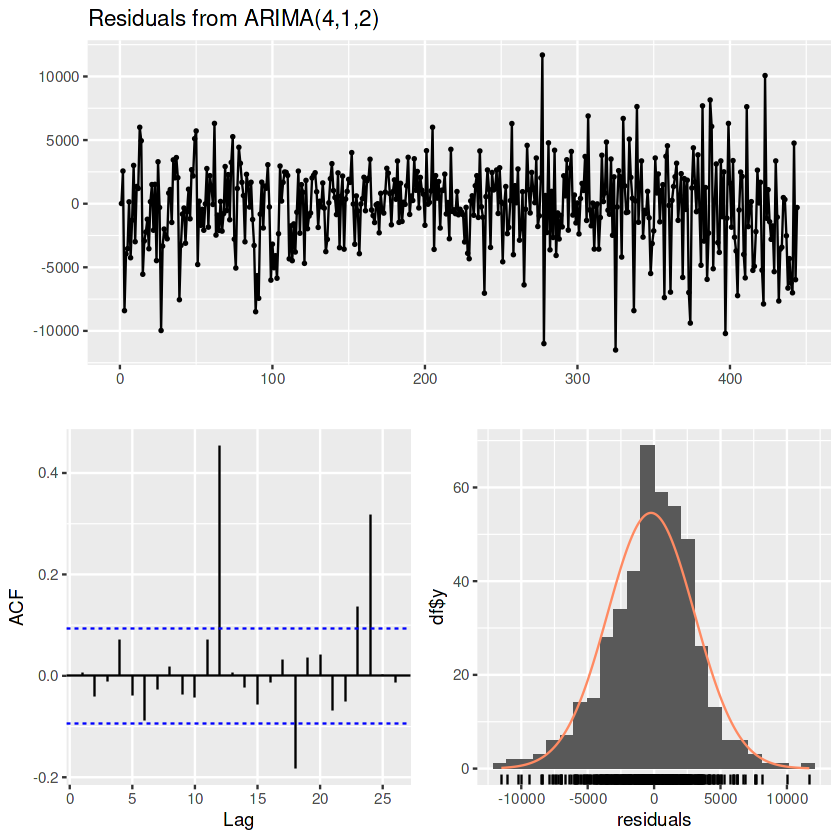

In [ ]:
Model.res<-arima(ts_data.res,order = c(4, 1, 2))
adf.test(Model.res$residuals)
checkresiduals(Model.res)

Nous constatons que les résidus du modèle ARIMA sont stationnaires mais ne sont pas du bruit blanc. Il y a une autocorrélation saisonnière qui n'a pas pu être capturée par la fonction `auto.sarima` : la fonction de test de saisonnalité utilisée (voir l'aide de auto.arima) n'a pas détecté la faible saisonnalité présente dans les données. Dans ce cas, on peut déterminer manuellement les paramètres (P,D,Q) du terme saisonnier. Pour ce faire, nous allons essayer d'éliminer la saisonnalité par différenciation (en appliquant l'opérateur $1-B^{12}$) en utilisant la fonction `diff(original_data, lag=12, D=order_of_differentiation)`. Nous devons ensuite déterminer les valeurs de $P$ et $Q$.

Nous prendrons $max(P,Q)=2$ et sélectionnerons le modèle ayant le $sigma^2$ le plus faible.

In [ ]:
arima(ts_data.res, order = c(4, 1, 2),seasonal = list(order = c(0,1,2), period = 12))$sigma2
arima(ts_data.res, order = c(4, 1, 2),seasonal = list(order = c(1,1,2), period = 12))$sigma2
arima(ts_data.res, order = c(4, 1, 2),seasonal = list(order = c(2,1,0), period = 12))$sigma2
arima(ts_data.res, order = c(4, 1, 2),seasonal = list(order = c(2,1,1), period = 12))$sigma2

[1] 7513194

[1] 7448104

[1] 8044716

[1] 7458587

On prend le 2ème modèle

Warning message in adf.test(Model.res.s$residuals):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  Model.res.s$residuals
Dickey-Fuller = -7.6338, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary



Call:
arima(x = ts_data.res, order = c(4, 1, 2), seasonal = list(order = c(1, 1, 2), 
    period = 12))

Coefficients:
         ar1      ar2      ar3      ar4      ma1     ma2     sar1    sma1
      0.8952  -0.0918  -0.0480  -0.1637  -1.4432  0.5785  -0.6764  0.0569
s.e.  0.2567   0.1185   0.0834   0.0573   0.2568  0.2379   0.1951  0.1785
         sma2
      -0.5367
s.e.   0.1161

sigma^2 estimated as 7448104:  log likelihood = -4025.49,  aic = 8070.98

Training set error measures:
                    ME     RMSE      MAE       MPE     MAPE      MASE
Training set -81.60925 2688.872 1938.489 -167.6843 298.5585 0.6579628
                     ACF1
Training set 0.0006397286


	Ljung-Box test

data:  Residuals from ARIMA(4,1,2)(1,1,2)[12]
Q* = 3.2867, df = 3, p-value = 0.3495

Model df: 9.   Total lags used: 12



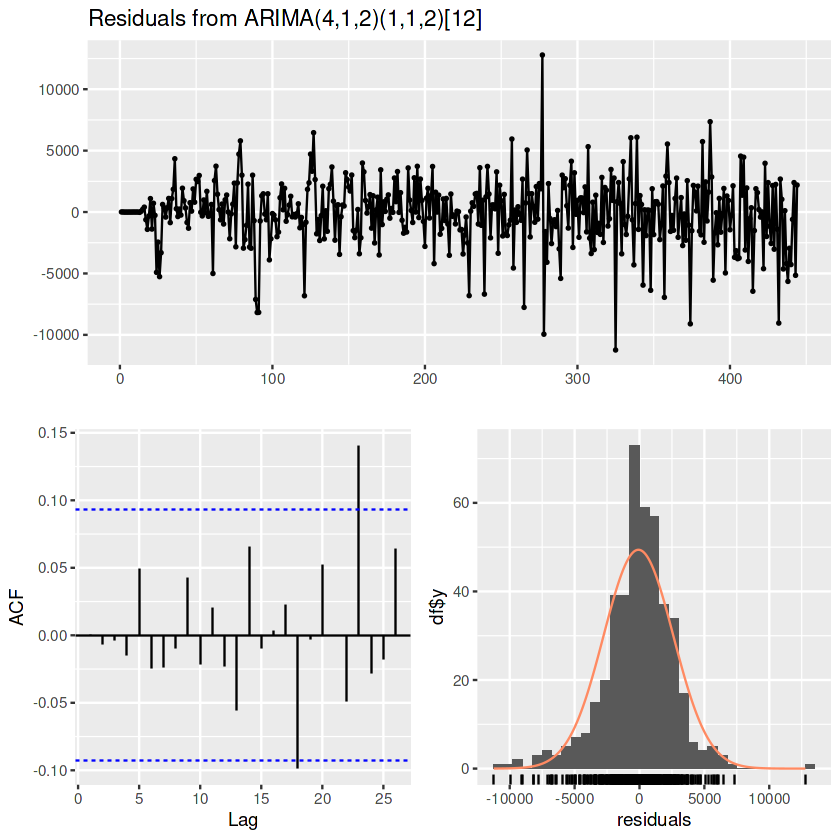

In [ ]:
Model.res.s<-arima(ts_data.res, order = c(4, 1, 2),seasonal = list(order = c(1,1,2), period = 12))
adf.test(Model.res.s$residuals)
summary(Model.res.s)
checkresiduals(Model.res.s)


Attaching package: ‘aTSA’


The following objects are masked from ‘package:tseries’:

    adf.test, kpss.test, pp.test


The following object is masked from ‘package:forecast’:

    forecast


The following object is masked from ‘package:graphics’:

    identify




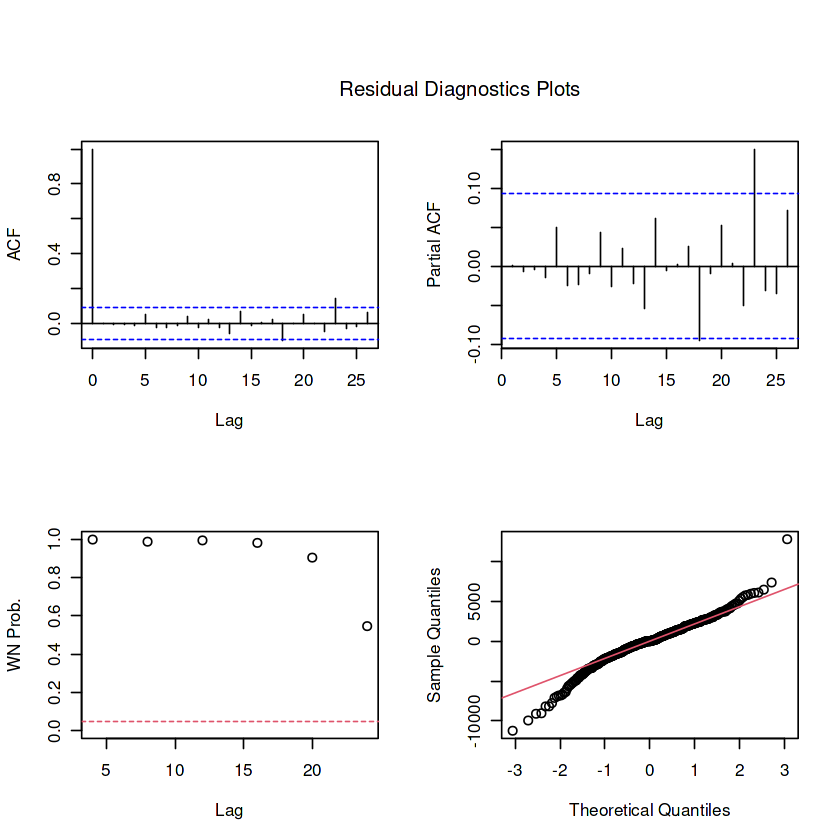

In [ ]:
library(aTSA)
ts.diag(Model.res.s)

# Prédictions

In [ ]:
Model.SARIMA.fit<-arima(ts_data, order = c(4, 1, 2),seasonal = list(order = c(1,1,2), period = 12))

Forecast for univariate time series: 
    Lead Forecast  S.E  Lower  Upper
445    1   228717 2720 223386 234048
446    2   217401 2984 211552 223250
447    3   251434 3224 245114 257753
448    4   248682 3447 241927 255438
449    5   259519 3548 252564 266473
450    6   257507 3627 250399 264616
451    7   261261 3694 254021 268502
452    8   261466 3758 254101 268831
453    9   240168 3831 232660 247675
454   10   253963 3916 246288 261639
455   11   238112 4014 230245 245979
456   12   241068 4121 232991 249146
457   13   227503 4581 218525 236481
458   14   216393 4801 206983 225803
459   15   251053 5008 241237 260870
460   16   248133 5201 237938 258327
461   17   259981 5347 249501 270461
462   18   258307 5477 247573 269041
463   19   262148 5597 251178 273118
464   20   262761 5712 251565 273957
465   21   240499 5830 229072 251926
466   22   254238 5952 242573 265904
467   23   238957 6078 227045 250869
468   24   240482 6206 228318 252647
469   25   227903 6518 215129 240678


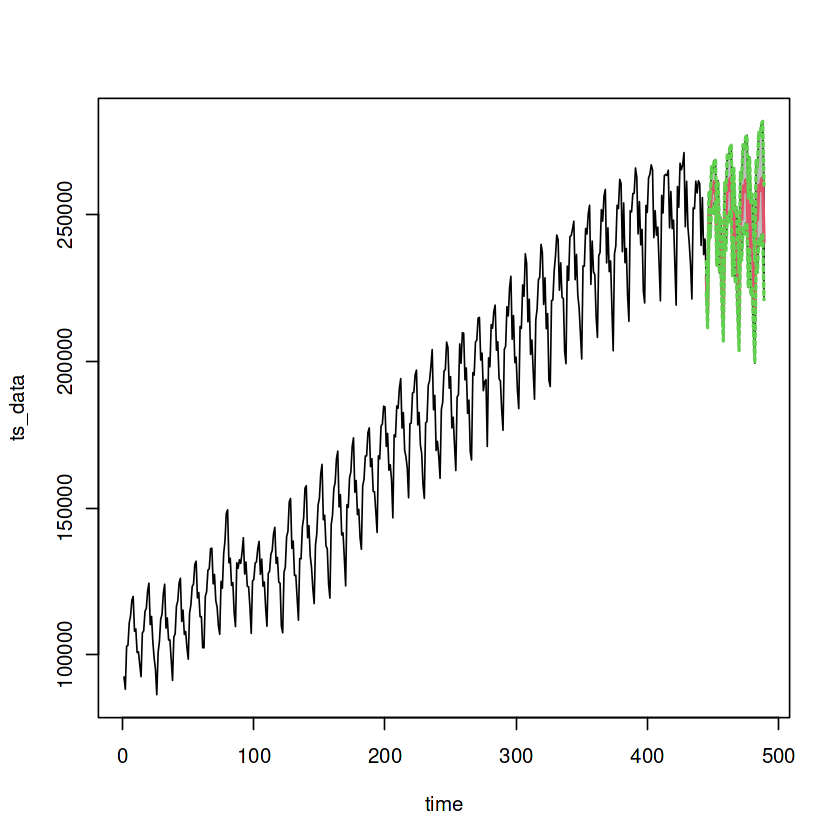

In [ ]:
forecast(Model.SARIMA.fit,45)

# DATA B2 : Unemployment Rate in Boston-Cambridge-Nashua, MA-NH (NECTA)BOST625URN

In [ ]:
dat2<-fredr(series_id = "BOST625URN",
          observation_start = as.Date("1992-01-01"),observation_end = as.Date("2019-12-31"))


In [ ]:
head(dat2)

date,series_id,value,realtime_start,realtime_end
<date>,<chr>,<dbl>,<date>,<date>
1992-01-01,BOST625URN,8.8,2024-04-28,2024-04-28
1992-02-01,BOST625URN,8.7,2024-04-28,2024-04-28
1992-03-01,BOST625URN,8.4,2024-04-28,2024-04-28
1992-04-01,BOST625URN,7.9,2024-04-28,2024-04-28
1992-05-01,BOST625URN,8.2,2024-04-28,2024-04-28
1992-06-01,BOST625URN,8.8,2024-04-28,2024-04-28


In [ ]:
tail(dat2)

date,series_id,value,realtime_start,realtime_end
<date>,<chr>,<dbl>,<date>,<date>
2019-07-01,BOST625URN,3.0,2024-04-28,2024-04-28
2019-08-01,BOST625URN,2.7,2024-04-28,2024-04-28
2019-09-01,BOST625URN,2.6,2024-04-28,2024-04-28
2019-10-01,BOST625URN,2.3,2024-04-28,2024-04-28
2019-11-01,BOST625URN,2.2,2024-04-28,2024-04-28
2019-12-01,BOST625URN,2.2,2024-04-28,2024-04-28


In [ ]:
dat2 <- subset(dat2, select = c(date, value))

head(dat2)

date,value
<date>,<dbl>
1992-01-01,8.8
1992-02-01,8.7
1992-03-01,8.4
1992-04-01,7.9
1992-05-01,8.2
1992-06-01,8.8


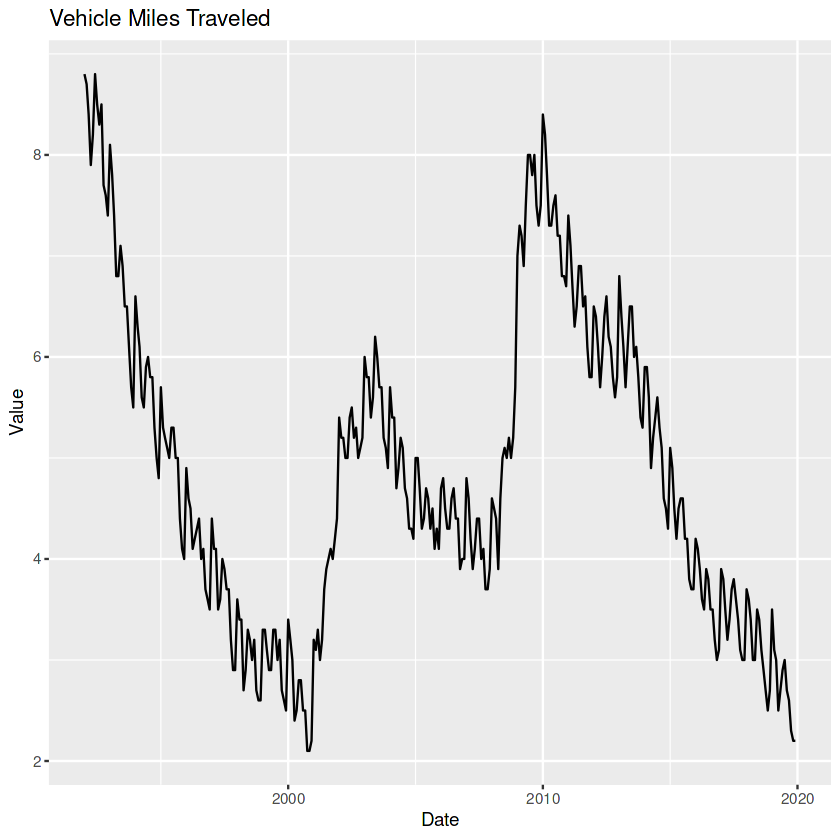

In [ ]:
ggplot(dat2, aes(x = date, y = value)) +
 geom_line() +
 labs(title = "Vehicle Miles Traveled", x = "Date", y = "Value")

In [ ]:
mean_value <- mean(dat2$value)
std_value <- sd(dat2$value)
cat("Mean:", mean_value, "\n")
cat("Standard Deviation:", std_value, "\n")

Mean: 4.83869 
Standard Deviation: 1.561187 


In [ ]:
ts_data <- ts(dat2$value, frequency = 12, start = c(1992,1))

In [ ]:
head(ts_data)

,Jan,Feb,Mar,Apr,May,Jun
1992,8.8,8.7,8.4,7.9,8.2,8.8


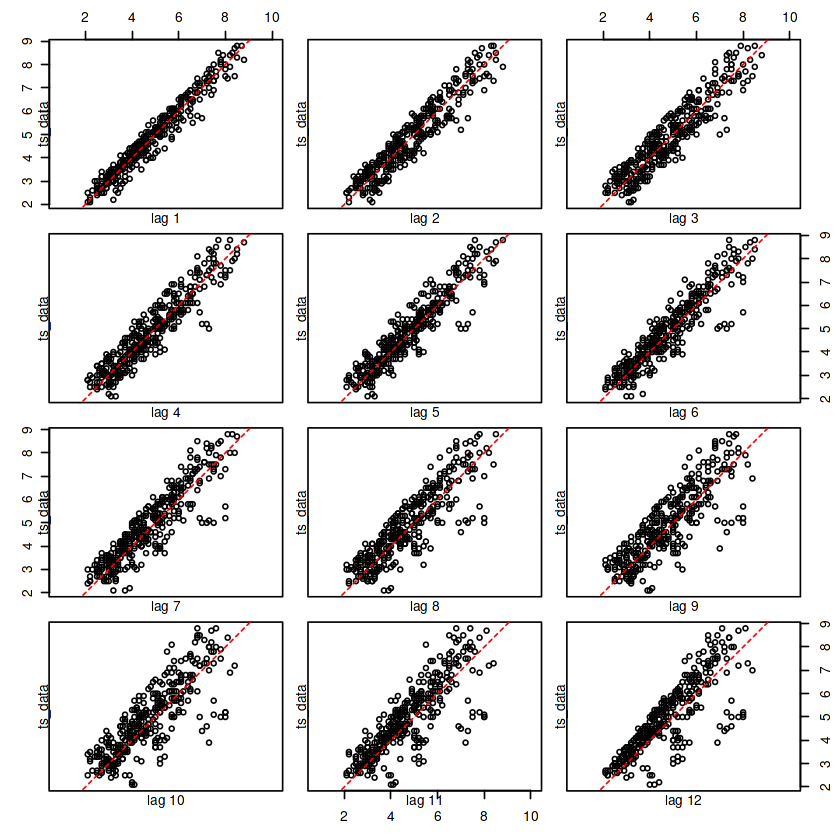

In [ ]:
lag.plot(ts_data,lag=12,layout=c(4,3),do.lines=FALSE,diag.col="red",col.main="blue")

# Analyse Statistique

**1.Décomposition paramétrique**
    
    l'amplitude des variations saisonnières varie en fonction du niveau, alors c'est une décomposition multiplicative.


In [ ]:
decomp <- decompose(ts_data, type = "multiplicative")
trend <- decomp$trend
seasonal <- decomp$seasonal
residuals <- decomp$random

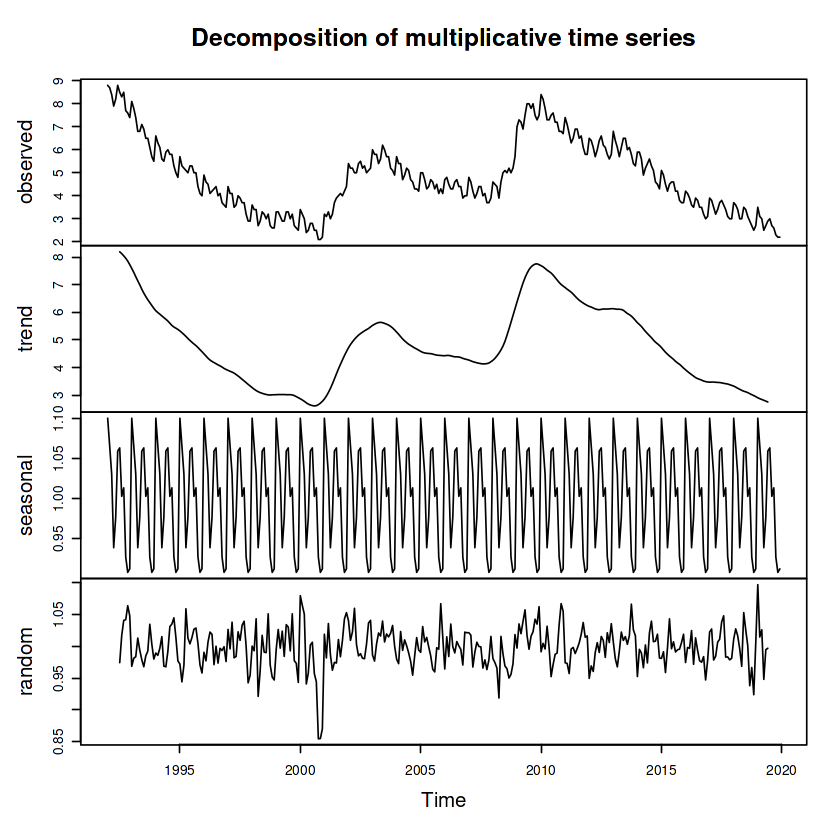

In [ ]:
plot(decomp)

**2.Auto-covariance**

In [ ]:
retard = 0
Xt = ts_data[1:(length(ts_data)-retard)]
Xt_retard = ts_data[(retard+1):length(ts_data)]
n = length(Xt)

cov(Xt,Xt_retard)

[1] 2.437305

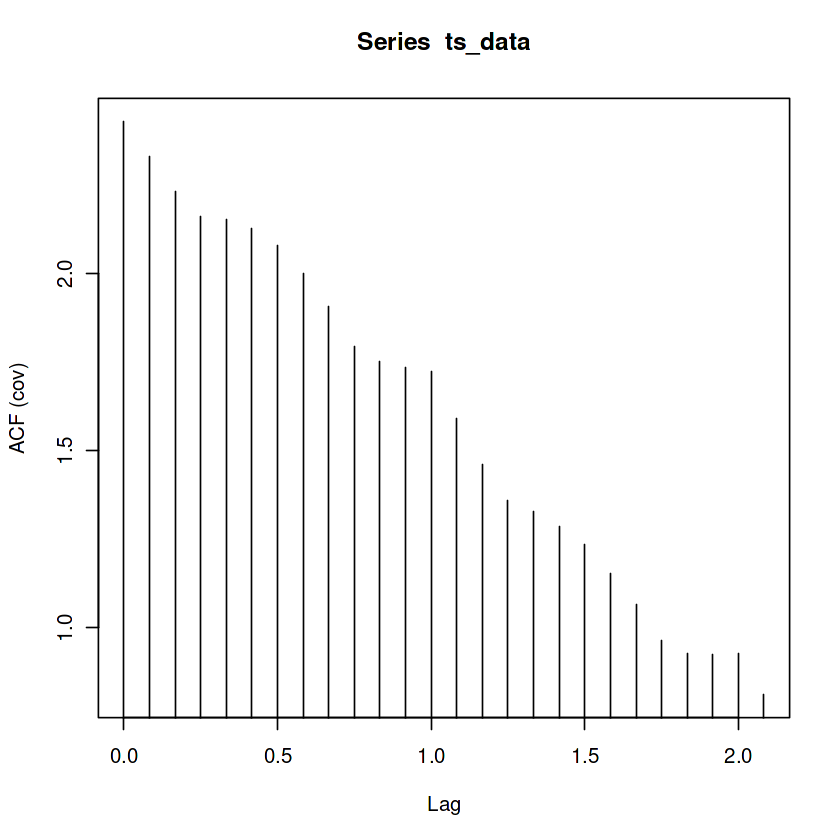

In [ ]:
autocovariance_AP <- acf(ts_data, plot = FALSE, type = "covariance")
plot(autocovariance_AP)

# Stationnarité

In [ ]:
rolling_mean = rollmean(ts_data, k=4, align='center')
c(length(rolling_mean),length(ts_data))

[1] 333 336

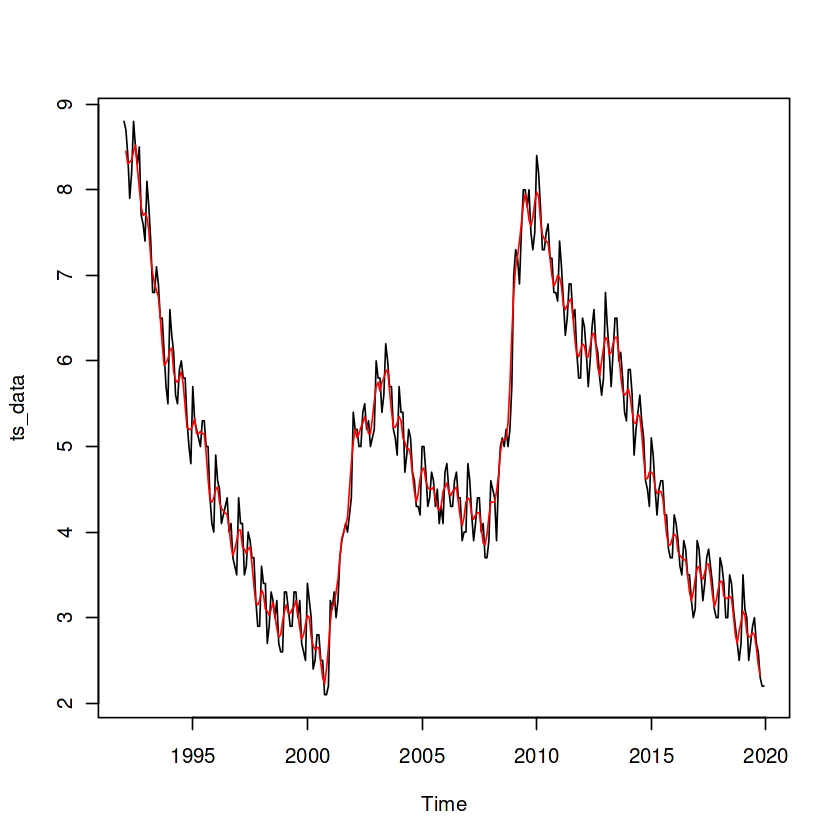

In [ ]:
plot(ts_data)
lines(rolling_mean,col='red')

# Test de stationnarité: Test ADF

In [ ]:
adf.test(ts_data)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag   ADF p.value
[1,]   0 -1.73  0.0830
[2,]   1 -1.71  0.0867
[3,]   2 -1.73  0.0826
[4,]   3 -2.14  0.0333
[5,]   4 -2.06  0.0406
[6,]   5 -2.24  0.0248
Type 2: with drift no trend 
     lag   ADF p.value
[1,]   0 -2.57   0.102
[2,]   1 -2.57   0.103
[3,]   2 -2.21   0.244
[4,]   3 -1.66   0.463
[5,]   4 -1.78   0.414
[6,]   5 -1.96   0.342
Type 3: with drift and trend 
     lag   ADF p.value
[1,]   0 -2.54   0.346
[2,]   1 -2.55   0.346
[3,]   2 -2.18   0.499
[4,]   3 -1.61   0.742
[5,]   4 -1.73   0.689
[6,]   5 -1.90   0.619
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


**P-valeur est inférieure à 0,05, on rejette l’hypothèse nulle et on conclut que la série temporelle est stationnaire.**

**Le test ADF suppose l'absence d'autocorrélation, de saisonnalité et de ruptures structurelles. Si l'une de ces hypothèses n'est pas respectée, les résultats du test ADF peuvent être trompeurs.**

# Test de Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

In [ ]:
kpss_test <- ur.kpss(ts_data)
summary(kpss_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.5127 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


**La statistique du test (0.5127) est supérieure à toutes la valeur critique fournie (0,463) pour le niveaux de signification de 5%. Cela suggère que nous rejetterions l'hypothèse nulle de stationnarité à pour notre niveau de signification.**

**Par conséquent, sur la base du test KPSS, les preuves suggèrent que notre série temporelle est non stationnaire.**

# Différenciation : Technique de stationnarisation

Cette méthode consiste à prendre la différence entre les valeurs de la série à des moments différents. La différence peut être prise plusieurs fois jusqu’à ce que la série soit stationnaire.

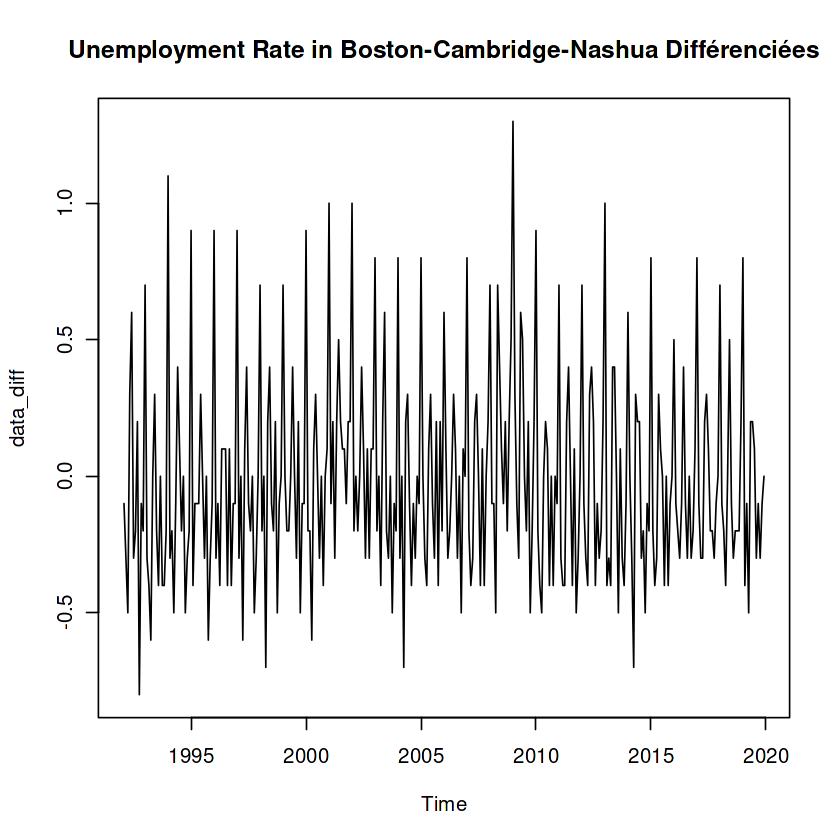

In [ ]:
data_diff <- diff(ts_data,lag =1,differences = 1)

plot(data_diff, type="l", main="Unemployment Rate in Boston-Cambridge-Nashua Différenciées")

In [ ]:
adf.test(data_diff)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -18.19    0.01
[2,]   1 -15.35    0.01
[3,]   2 -18.83    0.01
[4,]   3 -11.84    0.01
[5,]   4 -10.23    0.01
[6,]   5  -7.39    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -18.22    0.01
[2,]   1 -15.40    0.01
[3,]   2 -18.97    0.01
[4,]   3 -11.98    0.01
[5,]   4 -10.41    0.01
[6,]   5  -7.53    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -18.20    0.01
[2,]   1 -15.38    0.01
[3,]   2 -18.95    0.01
[4,]   3 -11.97    0.01
[5,]   4 -10.42    0.01
[6,]   5  -7.53    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


In [ ]:
kpss_test <- ur.kpss(data_diff)

summary(kpss_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.2749 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


**Cela suggère que nous acceptons l'hypothèse nulle de stationnarité à tous ces niveaux de signification.**

# Ajustement

Nous prendrons en considération les tendances et les schémas saisonniers

# 1. Régression linéaire simple:

In [ ]:
t=1:length(ts_data)
linear_model <- lm(ts_data ~ t)
summary(linear_model)


Call:
lm(formula = ts_data ~ t)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9141 -1.0762 -0.1964  1.0614  3.6975 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.3117075  0.1683474  31.552  < 2e-16 ***
t           -0.0028072  0.0008659  -3.242  0.00131 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.539 on 334 degrees of freedom
Multiple R-squared:  0.03051,	Adjusted R-squared:  0.02761 
F-statistic: 10.51 on 1 and 334 DF,  p-value: 0.001306


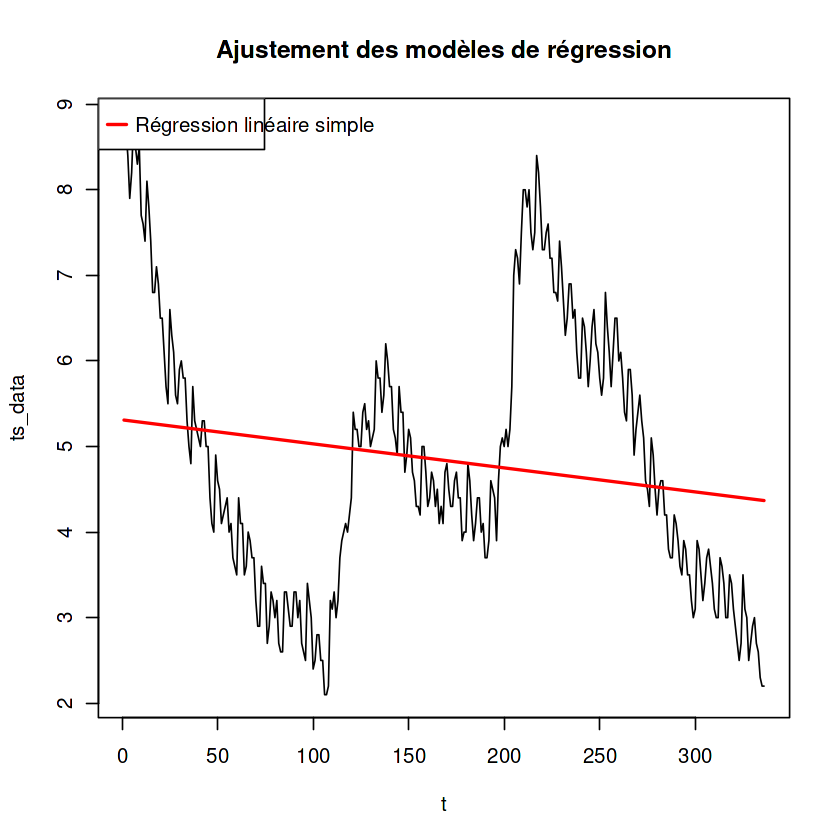

In [ ]:
plot(t, ts_data,type='l', main="Ajustement des modèles de régression")
lines(t, linear_model$fitted.values, col="red", lwd=2)
legend("topleft", legend="Régression linéaire simple",
      col="red", lty=1, lwd=2)

# 2. Régression linéaire multiple:

In [ ]:
poly_model <- lm(ts_data ~ t+I(t^2))
summary(poly_model)


Call:
lm(formula = ts_data ~ t + I(t^2))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9494 -1.0639 -0.2258  1.0421  3.6522 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.190e+00  2.537e-01  20.458   <2e-16 ***
t           -6.448e-04  3.476e-03  -0.185    0.853    
I(t^2)      -6.417e-06  9.990e-06  -0.642    0.521    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.541 on 333 degrees of freedom
Multiple R-squared:  0.03171,	Adjusted R-squared:  0.02589 
F-statistic: 5.452 on 2 and 333 DF,  p-value: 0.004677


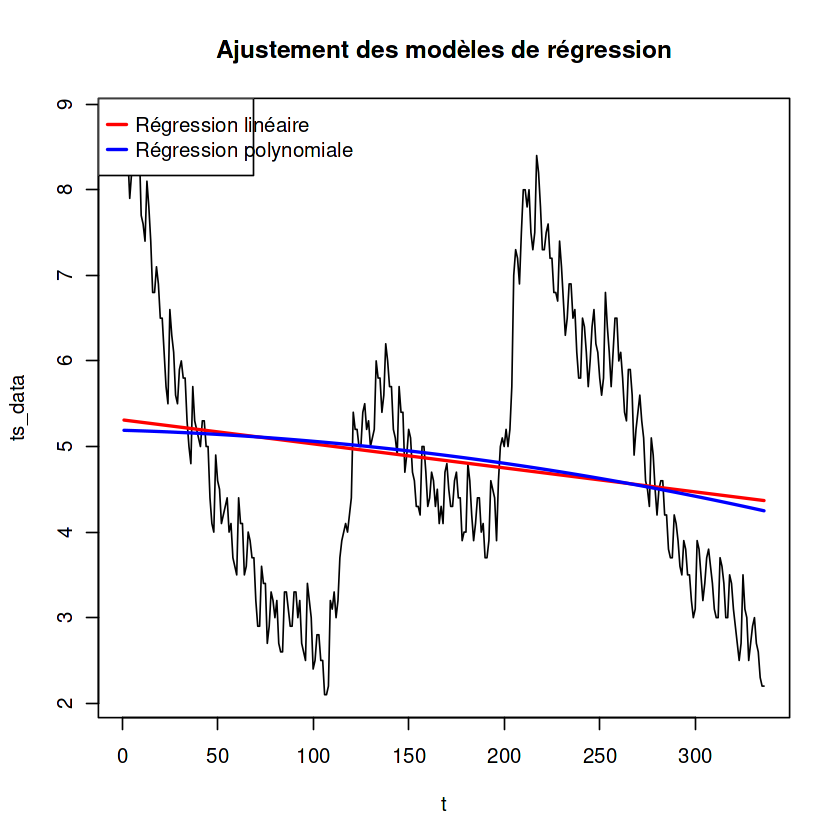

In [ ]:
plot(t,ts_data,type='l', main="Ajustement des modèles de régression")
lines(t, linear_model$fitted.values, col="red", lwd=2)
lines(t, poly_model$fitted.values, col="blue", lwd=2)
legend("topleft", legend=c("Régression linéaire", "Régression polynomiale"),
      col=c("red", "blue"), lty=1, lwd=2)

# 3. Prédiciton des valeurs au futur

In [ ]:
t_futur = (length(ts_data)+1):(length(ts_data)+20)
predict_linear=predict(linear_model, newdata=data.frame(t = t_futur))
predict_poly = predict(poly_model, newdata=data.frame(t = t_futur))

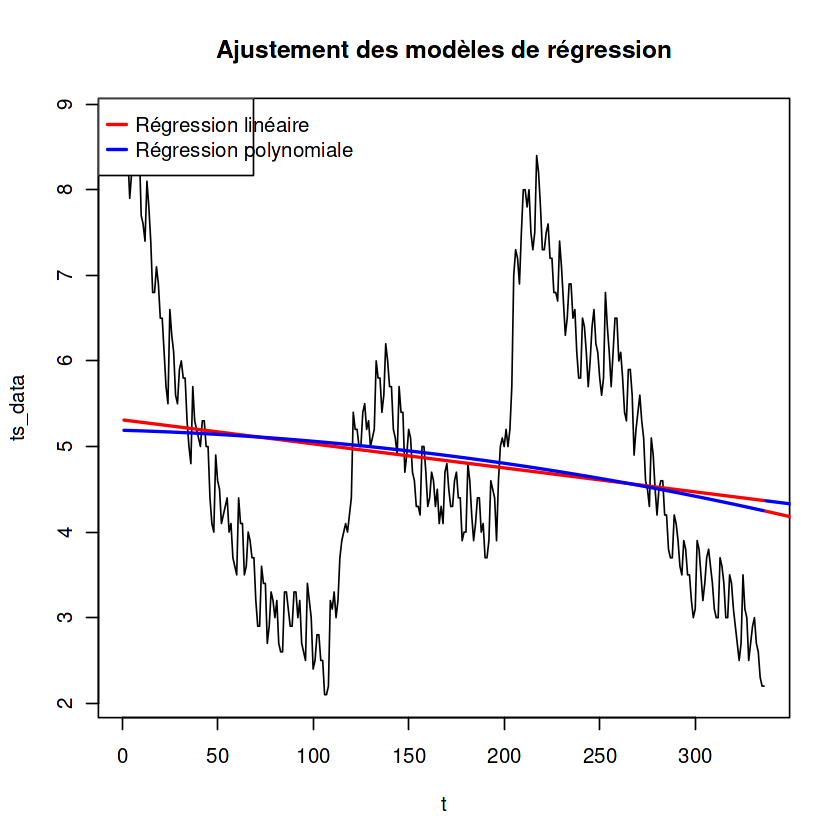

In [ ]:
plot(t,ts_data,type='l', main="Ajustement des modèles de régression")
lines(t, linear_model$fitted.values, col="red", lwd=2)
lines(t, poly_model$fitted.values, col="blue", lwd=2)
legend("topleft", legend=c("Régression linéaire", "Régression polynomiale"),
      col=c("red", "blue"), lty=1, lwd=2)

lines(t_futur,predict_linear,col="blue", lwd=2)
lines(t_futur,predict_poly,col="red", lwd=2)

# 4. Analyse des résidus

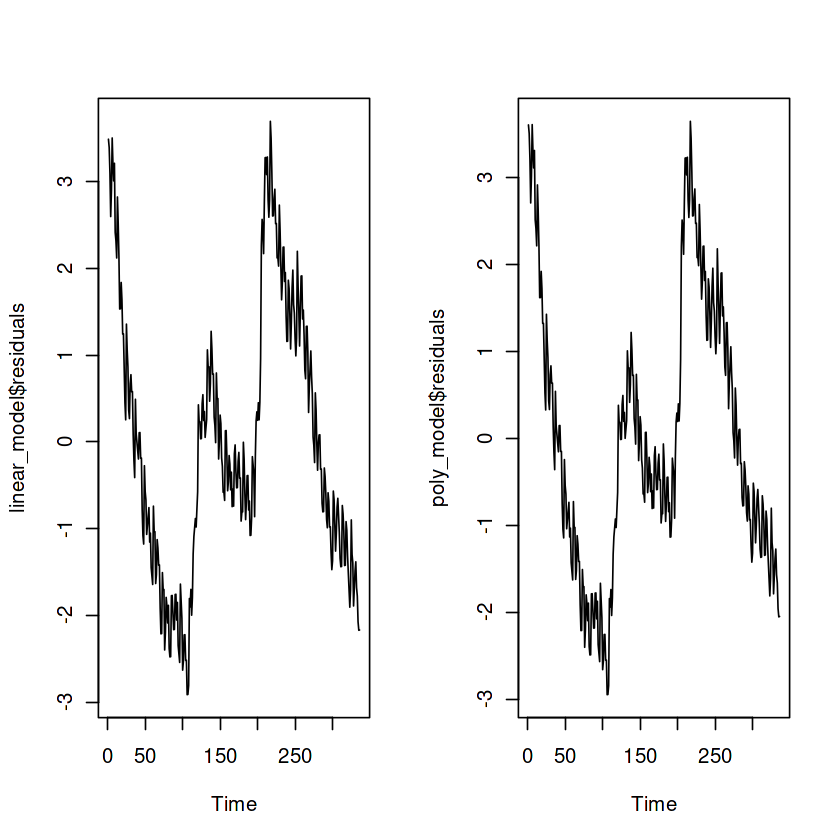

In [ ]:
par(mfrow=c(1,2))
plot.ts(linear_model$residuals)
plot.ts(poly_model$residuals)

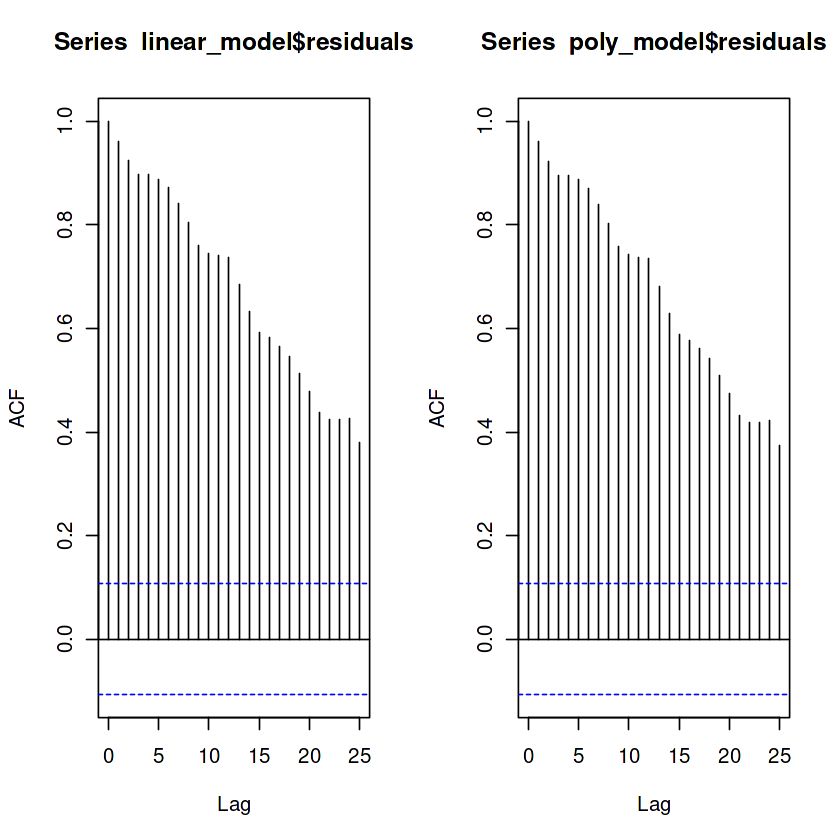

In [ ]:
par(mfrow=c(1,2))
acf(linear_model$residuals)
acf(poly_model$residuals)

**On a une structure temporelle ou saisonnière non capturée par le modèle.**

# 5. Ajustement des composantes saisonnières :

In [ ]:
n= length(ts_data)
t=1 : length(ts_data)
transformer = function(t){
MC=matrix(0, length(t), 6)
MS=matrix(0, length(t), 6)
for (i in 1:6)
  MC[,i]=cos(2 *pi *t * i/12)
for (i in 1:6)
  MS[,i]=sin(2 * pi * t * i/12)
return(list(MC=MC, MS=MS))
}
mixed_model=lm(ts_data~poly(t,2,raw=TRUE) + transformer(t)$MC + transformer(t)$MS)
summary(mixed_model)


Call:
lm(formula = ts_data ~ poly(t, 2, raw = TRUE) + transformer(t)$MC + 
    transformer(t)$MS)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.5775 -1.0513 -0.2632  0.9785  3.3533 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              5.174e+00  2.527e-01  20.476  < 2e-16 ***
poly(t, 2, raw = TRUE)1 -5.552e-04  3.462e-03  -0.160  0.87270    
poly(t, 2, raw = TRUE)2 -6.409e-06  9.949e-06  -0.644  0.51989    
transformer(t)$MC1      -1.268e-01  1.184e-01  -1.071  0.28504    
transformer(t)$MC2      -2.176e-02  1.184e-01  -0.184  0.85427    
transformer(t)$MC3      -1.646e-01  1.184e-01  -1.390  0.16542    
transformer(t)$MC4       1.234e-03  1.185e-01   0.010  0.99169    
transformer(t)$MC5      -8.342e-02  1.191e-01  -0.701  0.48410    
transformer(t)$MC6      -7.860e-02  9.204e-02  -0.854  0.39376    
transformer(t)$MS1       1.473e-01  1.185e-01   1.244  0.21457    
transformer(t)$MS2       3.365e-01  1.184e-01   2.842  

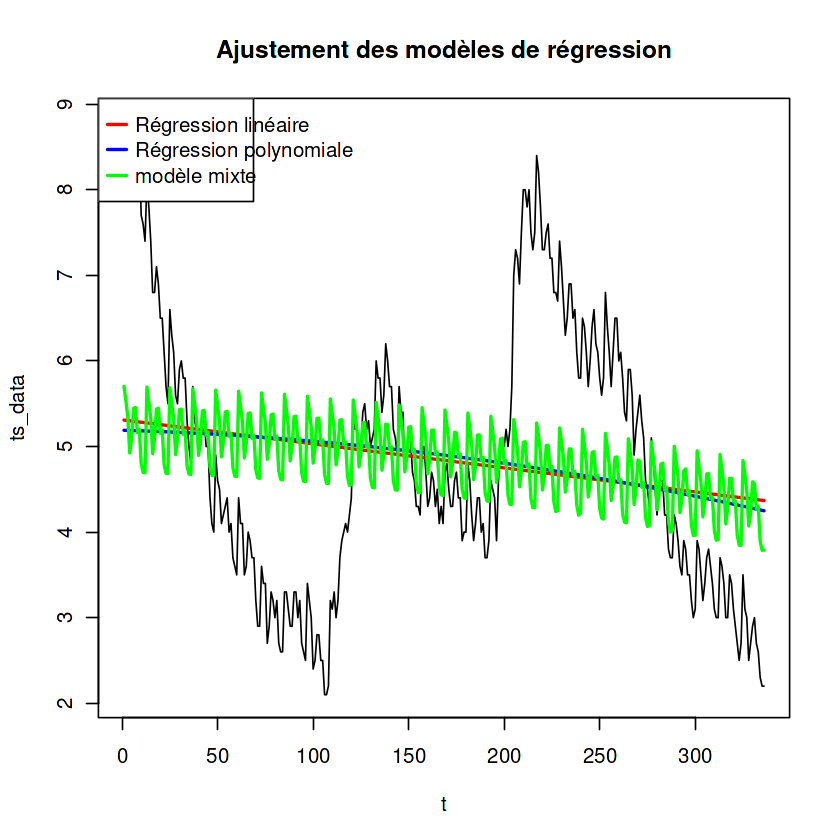

In [ ]:
plot(t,ts_data,type='l', main="Ajustement des modèles de régression")
lines(t, linear_model$fitted.values, col="red", lwd=2)
lines(t, poly_model$fitted.values, col="blue", lwd=2)
lines(t, mixed_model$fitted.values, col="green", lwd=2)

legend("topleft", legend=c("Régression linéaire", "Régression polynomiale", "modèle mixte"),
      col=c("red", "blue", "green"), lty=1, lwd=2)

In [ ]:
length(ts_data)

[1] 336

In [ ]:
t_futur = 337:400
nouvelle_observation <- data.frame(t=t_futur,MC=transformer(t_futur)$MC, MS=transformer(t_futur)$MS)

# Utiliser la fonction predict pour faire la prédiction
prediction <- predict(mixed_model, newdata = nouvelle_observation)

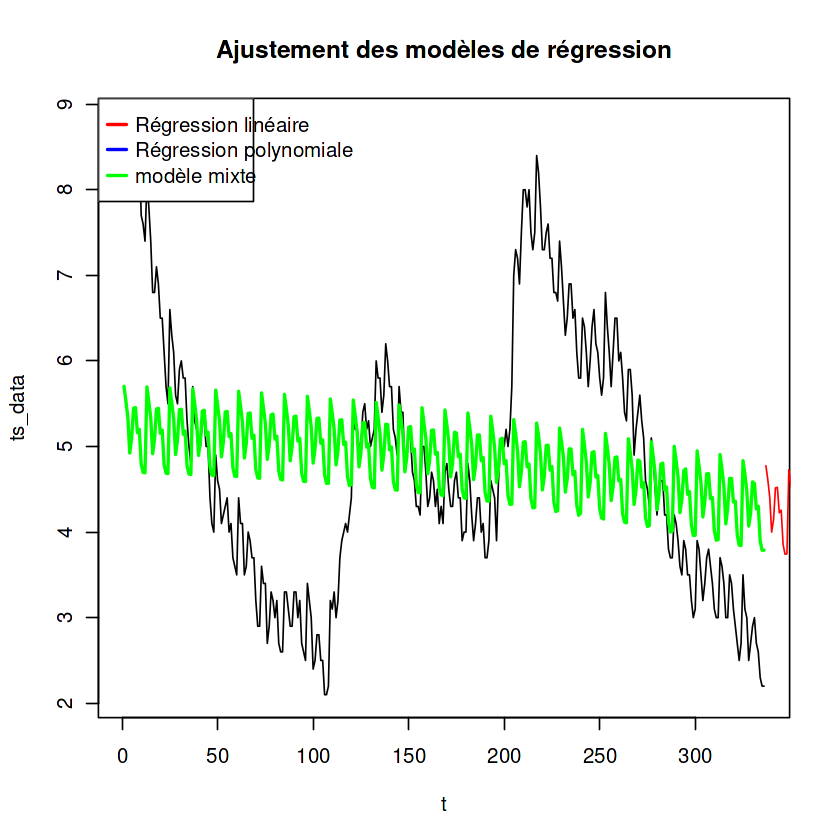

In [ ]:
plot(t,ts_data,type='l', main="Ajustement des modèles de régression")

lines(t, mixed_model$fitted.values, col="green", lwd=2)
lines(t_futur,prediction,col="red",type='l')


legend("topleft", legend=c("Régression linéaire", "Régression polynomiale", "modèle mixte"),
      col=c("red", "blue", "green"), lty=1, lwd=2)

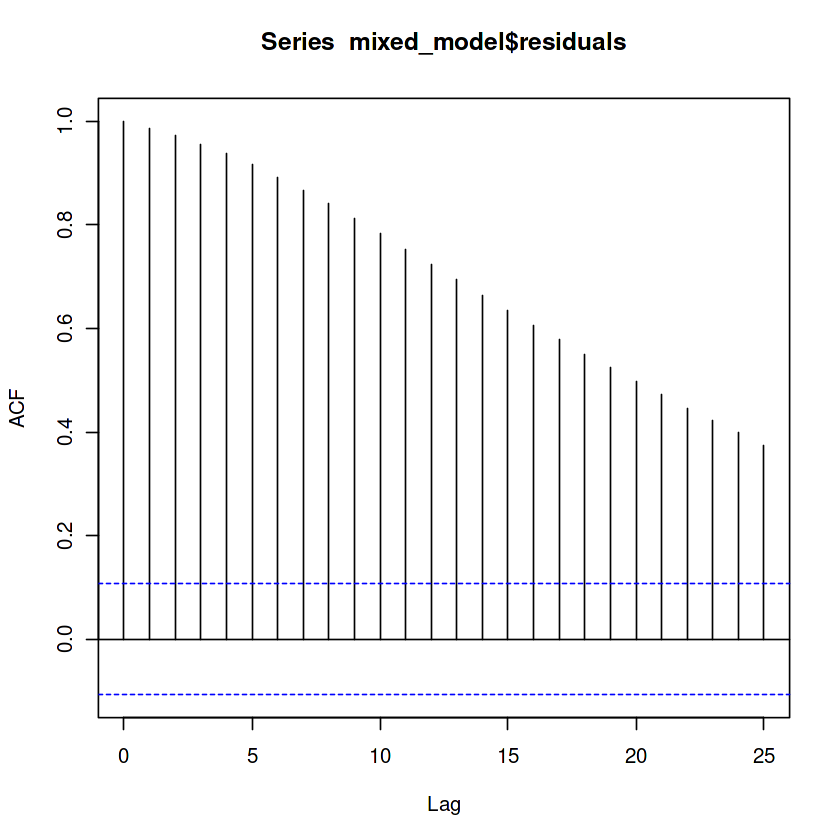

In [ ]:
acf(mixed_model$residuals)

En observant la fonction ACF, une autocorrélation significative et lantement décroissante dans les résidus de ce modèle indique que le modèle ne capture pas complètement la variabilité des données et qu’il y a des informations non expliquées.

# 6. Comparaison des modèlesAIC(linear_model, poly_model, mixed_model)

In [ ]:
AIC(linear_model, poly_model, mixed_model)
BIC(linear_model, poly_model, mixed_model)

,df,AIC
,<dbl>,<dbl>
linear_model,3,1247.454
poly_model,4,1249.038
mixed_model,16,1257.930


,df,BIC
,<dbl>,<dbl>
linear_model,3,1258.906
poly_model,4,1264.307
mixed_model,16,1319.004


Le modèle linéaire est le meilleur selon l'AIC et le BIC

# ARIMA

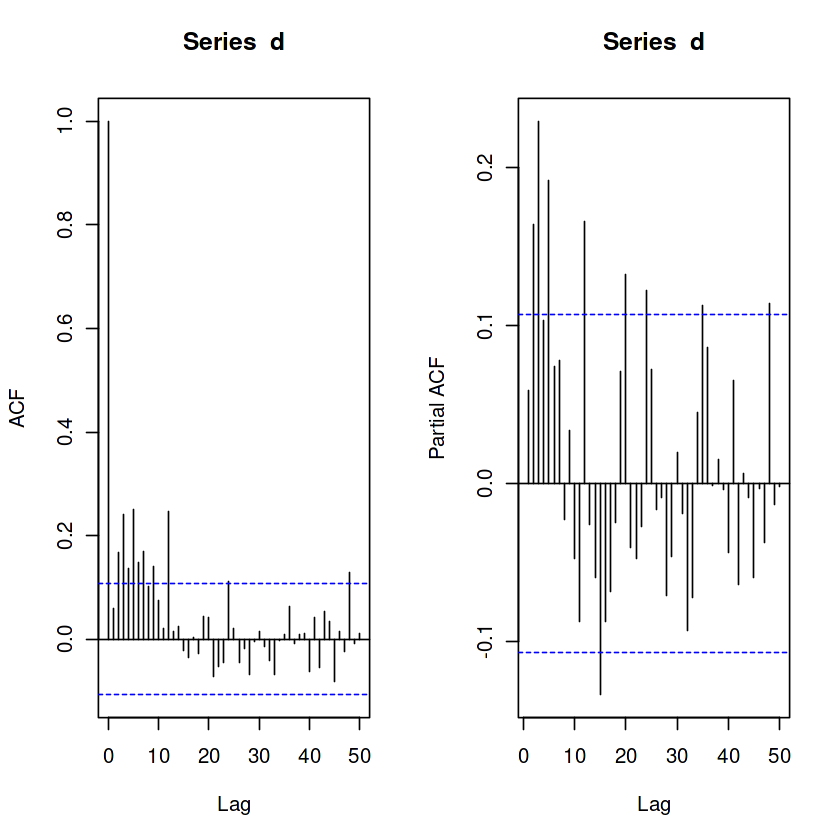

In [ ]:
d = diff(mixed_model$residuals)
par(mfrow=c(1,2))
acf(d, 50)
pacf(d,50)

Nous pouvons constater qu'il est difficile de déterminer **p** et **q** à partir des tracés de l'acf et du pacf.
Nous pouvons utiliser la fonction **auto.arima()** du module **forecast**.

In [ ]:
 ts_data.res<-mixed_model$residuals

In [ ]:
library(forecast)
ARIMA=auto.arima(ts_data.res,d=1,trace=TRUE)



 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : -311.9342
 ARIMA(0,1,0) with drift         : -281.2766
 ARIMA(1,1,0) with drift         : -279.7147
 ARIMA(0,1,1) with drift         : -280.1289
 ARIMA(0,1,0)                    : -280.6591
 ARIMA(1,1,2) with drift         : -315.0139
 ARIMA(0,1,2) with drift         : -285.0131
 ARIMA(1,1,1) with drift         : -303.6137
 ARIMA(1,1,3) with drift         : -316.1729
 ARIMA(0,1,3) with drift         : -293.842
 ARIMA(2,1,3) with drift         : -315.1475
 ARIMA(1,1,4) with drift         : -314.1382
 ARIMA(0,1,4) with drift         : -293.3134
 ARIMA(2,1,4) with drift         : -313.1848
 ARIMA(1,1,3)                    : -317.754
 ARIMA(0,1,3)                    : -294.1529
 ARIMA(1,1,2)                    : -316.5938
 ARIMA(2,1,3)                    : -316.867
 ARIMA(1,1,4)                    : -315.7304
 ARIMA(0,1,2)                    : -284.9946
 ARIMA(0,1,4)                    : -293.71

le meilleur modèle c'est **ARIMA(4,1,2)**

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -18.27    0.01
[2,]   1 -12.76    0.01
[3,]   2 -10.31    0.01
[4,]   3  -9.59    0.01
[5,]   4  -7.82    0.01
[6,]   5  -7.24    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -18.26    0.01
[2,]   1 -12.76    0.01
[3,]   2 -10.32    0.01
[4,]   3  -9.60    0.01
[5,]   4  -7.84    0.01
[6,]   5  -7.27    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -18.24    0.01
[2,]   1 -12.76    0.01
[3,]   2 -10.31    0.01
[4,]   3  -9.60    0.01
[5,]   4  -7.84    0.01
[6,]   5  -7.29    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 

	Ljung-Box test

data:  Residuals from ARIMA(1,1,3)
Q* = 4.4869, df = 6, p-value = 0.6111

Model df: 4.   Total lags used: 10



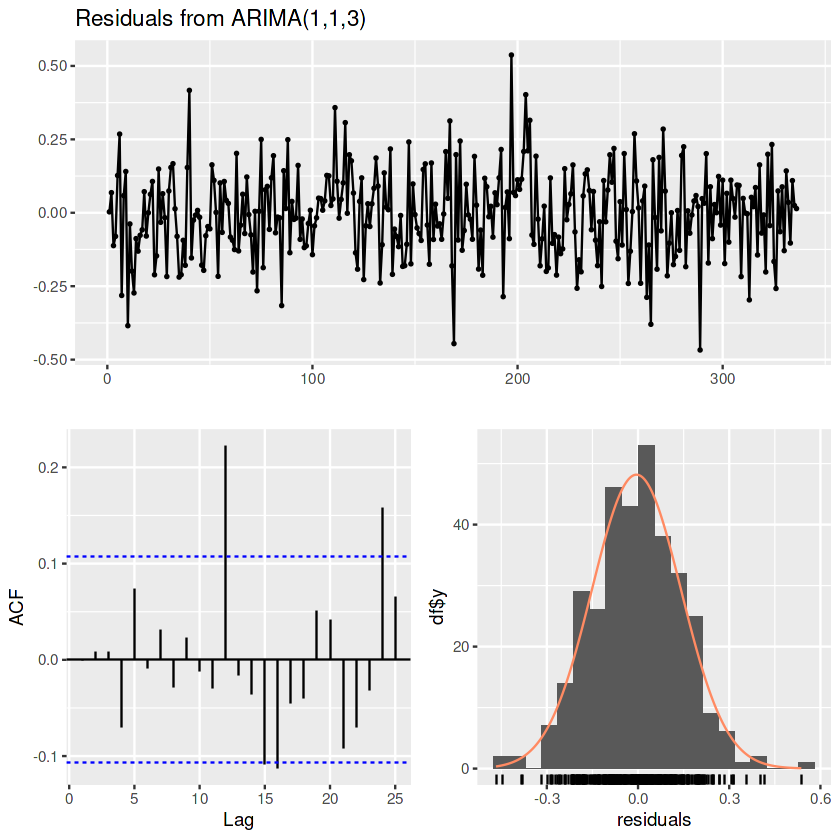

In [ ]:
Model.res<-arima(ts_data.res,order = c(1, 1, 3))
adf.test(Model.res$residuals)
checkresiduals(Model.res)

Nous constatons que les résidus du modèle ARIMA sont stationnaires mais ne sont pas du bruit blanc. Il y a une autocorrélation saisonnière qui n'a pas pu être capturée par la fonction `auto.sarima` : la fonction de test de saisonnalité utilisée (voir l'aide de auto.arima) n'a pas détecté la faible saisonnalité présente dans les données. Dans ce cas, on peut déterminer manuellement les paramètres (P,D,Q) du terme saisonnier. Pour ce faire, nous allons essayer d'éliminer la saisonnalité par différenciation (en appliquant l'opérateur $1-B^{12}$) en utilisant la fonction `diff(original_data, lag=12, D=order_of_differentiation)`. Nous devons ensuite déterminer les valeurs de $P$ et $Q$.

Nous prendrons $max(P,Q)=2$ et sélectionnerons le modèle ayant le $sigma^2$ le plus faible.

$sigma^2$ représente la variance de la composante d'erreur résiduelle du modèle, c'est-à-dire la variance des résidus après ajustement du modèle.

In [ ]:
arima(ts_data.res, order = c(1, 1, 3),seasonal = list(order = c(0,1,2), period = 12))$sigma2
arima(ts_data.res, order = c(1, 1, 3),seasonal = list(order = c(1,1,2), period = 12))$sigma2
arima(ts_data.res, order = c(1, 1, 3),seasonal = list(order = c(2,1,0), period = 12))$sigma2
arima(ts_data.res, order = c(1, 1, 3),seasonal = list(order = c(2,1,1), period = 12))$sigma2

[1] 0.02036861

[1] 0.02035293

[1] 0.02414891

[1] 0.02034897

On prend le 4ème modèle

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -18.28    0.01
[2,]   1 -12.74    0.01
[3,]   2 -10.24    0.01
[4,]   3  -9.54    0.01
[5,]   4  -7.93    0.01
[6,]   5  -7.33    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -18.26    0.01
[2,]   1 -12.73    0.01
[3,]   2 -10.23    0.01
[4,]   3  -9.53    0.01
[5,]   4  -7.93    0.01
[6,]   5  -7.32    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -18.26    0.01
[2,]   1 -12.73    0.01
[3,]   2 -10.24    0.01
[4,]   3  -9.55    0.01
[5,]   4  -7.95    0.01
[6,]   5  -7.35    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 



Call:
arima(x = ts_data.res, order = c(1, 1, 3), seasonal = list(order = c(2, 1, 1), 
    period = 12))

Coefficients:
         ar1      ma1     ma2     ma3    sar1    sar2     sma1
      0.8866  -0.9481  0.1250  0.1301  0.0925  0.0081  -0.8725
s.e.  0.0422   0.0693  0.0813  0.0621  0.0793  0.0734   0.0617

sigma^2 estimated as 0.02035:  log likelihood = 163.04,  aic = -310.08

Training set error measures:
                      ME     RMSE       MAE      MPE    MAPE      MASE
Training set 0.002873447 0.139865 0.1101223 17.66165 46.2877 0.8964856
                     ACF1
Training set -0.001073983


	Ljung-Box test

data:  Residuals from ARIMA(1,1,3)(2,1,1)[12]
Q* = 7.4126, df = 3, p-value = 0.05985

Model df: 7.   Total lags used: 10



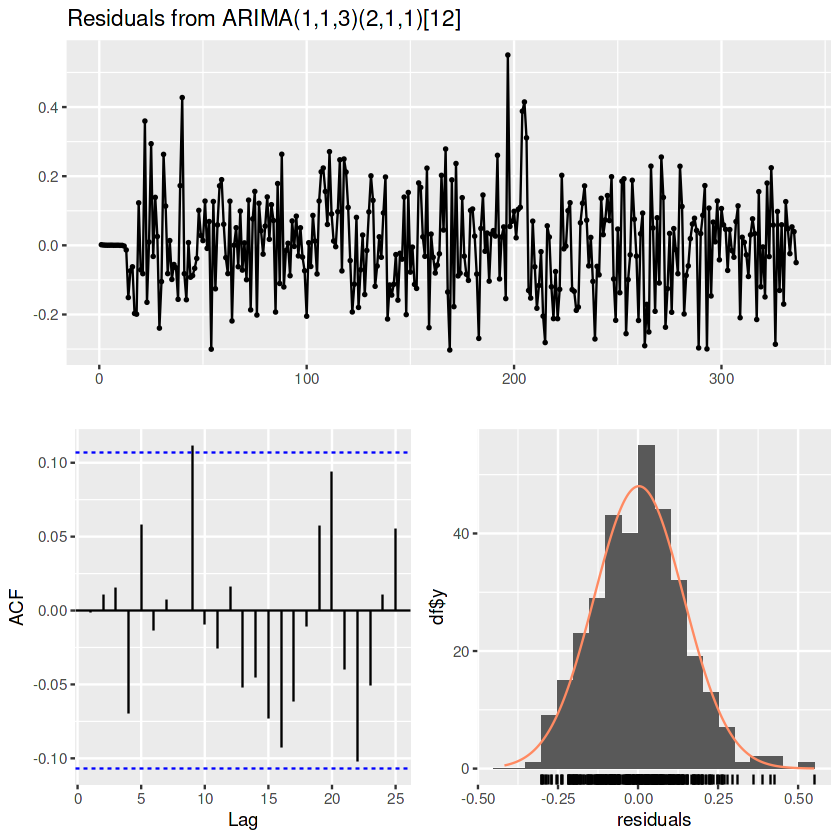

In [ ]:
Model.res.s<-arima(ts_data.res, order = c(1, 1, 3),seasonal = list(order = c(2,1,1), period = 12))
adf.test(Model.res.s$residuals)
summary(Model.res.s)
checkresiduals(Model.res.s)

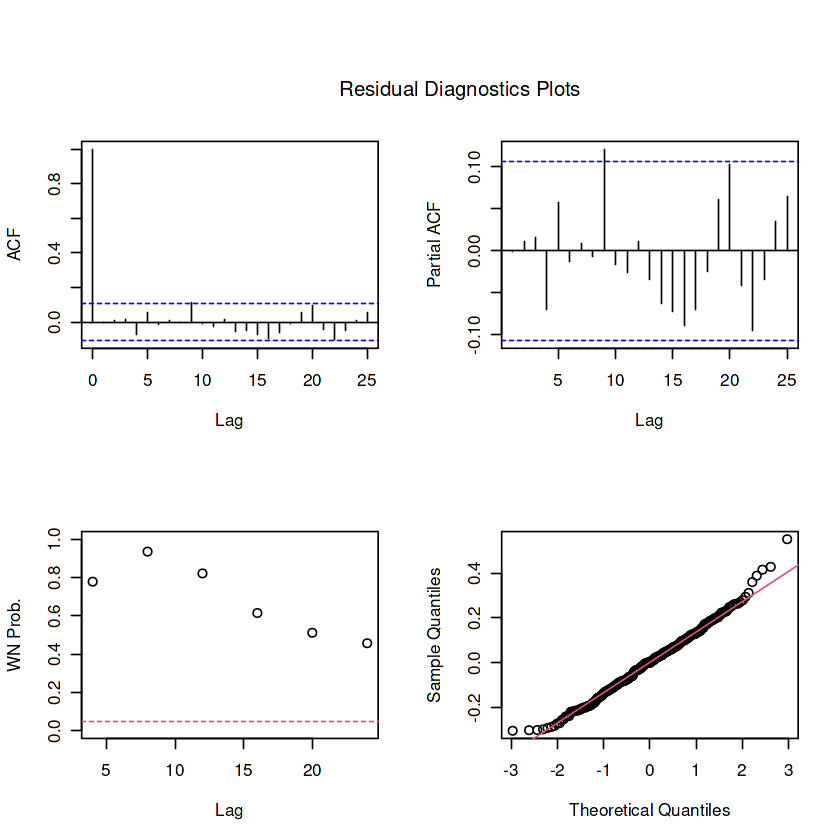

In [ ]:
ts.diag(Model.res.s)

# Prédictions

In [ ]:
Model.SARIMA.fit<-arima(ts_data, order = c(1, 1, 3),seasonal = list(order = c(2,1,1), period = 12))

Forecast for univariate time series: 
    Lead Forecast   S.E   Lower Upper
337    1     2.98 0.142  2.7041  3.26
338    2     2.80 0.195  2.4153  3.18
339    3     2.58 0.242  2.1051  3.05
340    4     2.16 0.297  1.5794  2.74
341    5     2.35 0.356  1.6495  3.04
342    6     2.66 0.417  1.8430  3.48
343    7     2.70 0.479  1.7573  3.64
344    8     2.39 0.542  1.3239  3.45
345    9     2.34 0.605  1.1511  3.52
346   10     2.00 0.668  0.6892  3.31
347   11     1.87 0.730  0.4438  3.30
348   12     1.91 0.790  0.3569  3.46
349   13     2.68 0.863  0.9881  4.37
350   14     2.51 0.932  0.6803  4.33
351   15     2.28 1.000  0.3183  4.24
352   16     1.87 1.068 -0.2262  3.96
353   17     2.05 1.136 -0.1746  4.28
354   18     2.38 1.203  0.0178  4.73
355   19     2.41 1.269 -0.0813  4.89
356   20     2.10 1.335 -0.5207  4.71
357   21     2.05 1.399 -0.6915  4.79
358   22     1.71 1.463 -1.1594  4.58
359   23     1.58 1.525 -1.4082  4.57
360   24     1.62 1.587 -1.4930  4.73
361   25    

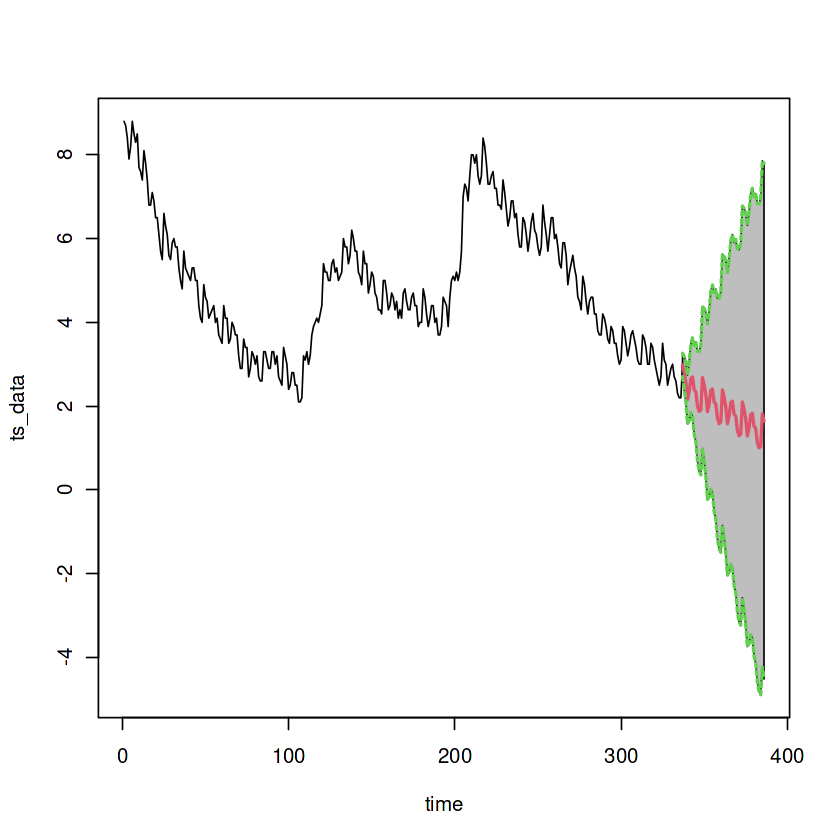

In [ ]:
forecast(Model.SARIMA.fit,50)